## Machine Learnging Applications in Finance {-}

### Team Members: {-}

#### Marcel Santos de Carvalho, id 79803 {-}
#### Alex Palacios, id 73713 {-}
#### Artem Maiorov, id 79793{-}


# QUESTION 1

## Trading Analysis: Microsoft Stock Return Prediction

<a id='0'></a>
## 1. Problem Definition

In this question, we will be comparing a Multilayer Percepton model to other regression models such as LASSO, RIDGE, AdaBoost Regressor, Random Forest, etc. We will be trying to predict the weekly retunr from Microsoft by useing differents feautres such as returns form the following assets:

* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX

We will extract the datasets from Yahoo Finance and the FRED database at the St Louis Fed. We will use closing prices from 2010 on.


<a id='1'></a>
## 2. Getting Started

In [1]:
#!pip install pandas_datareader
#!pip install yfinance

In [3]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Cross Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Model selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix

In [4]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
### 2.2. Loading the Data

In this step we will extract the data specified above using pandas datareader method. The stock price data is coming from Yahoo while the stock index and currency data is coming fromn FRED.

In [5]:
import yfinance as yf
import pandas_datareader.data as web
import datetime

# 10 year period
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022, 1, 1)

stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXUSEU', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

# We can use pandas_datareader or yfinance
# stk_data = yf.download(stk_tickers)

stk_data = web.DataReader(stk_tickers, 'yahoo', start = start, end = end)
ccy_data = web.DataReader(ccy_tickers, 'fred', start = start, end = end)
idx_data = web.DataReader(idx_tickers, 'fred', start = start, end = end)

In [6]:
stk_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-01-03 to 2021-12-31
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, MSFT)   2517 non-null   float64
 1   (Adj Close, IBM)    2517 non-null   float64
 2   (Adj Close, GOOGL)  2517 non-null   float64
 3   (Close, MSFT)       2517 non-null   float64
 4   (Close, IBM)        2517 non-null   float64
 5   (Close, GOOGL)      2517 non-null   float64
 6   (High, MSFT)        2517 non-null   float64
 7   (High, IBM)         2517 non-null   float64
 8   (High, GOOGL)       2517 non-null   float64
 9   (Low, MSFT)         2517 non-null   float64
 10  (Low, IBM)          2517 non-null   float64
 11  (Low, GOOGL)        2517 non-null   float64
 12  (Open, MSFT)        2517 non-null   float64
 13  (Open, IBM)         2517 non-null   float64
 14  (Open, GOOGL)       2517 non-null   float64
 15  (Volume, MSFT)      2517 non-null   f

As we can see, we obtained a multi index data frame containing the Volume traded, the open price, the lowest price, the highest price, the close price and the adjusted close price for each stock. The time series has 2,517 data points.

In [7]:
ccy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2610 entries, 2012-01-02 to 2021-12-31
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEXUSEU  2500 non-null   float64
 1   DEXUSUK  2500 non-null   float64
dtypes: float64(2)
memory usage: 61.2 KB


Here, we show the obtained data frame of fx rates which has 2,500 dates.

In [8]:
ccy_data.columns = ['USDEUR', 'GBPUSD'] # We rename the columns

In [9]:
idx_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2610 entries, 2012-01-02 to 2021-12-31
Freq: B
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP500   2470 non-null   float64
 1   DJIA    2470 non-null   float64
 2   VIXCLS  2517 non-null   float64
dtypes: float64(3)
memory usage: 81.6 KB


Finally, we obtained the index time series containing 2,470 dates for the S&P and the DOW and 2,517 for the VIX. We will solve this issue further in the analysis.

In [10]:
stk_data.tail()

Attributes   Adj Close                                Close              \
Symbols           MSFT         IBM        GOOGL        MSFT         IBM   
Date                                                                      
2021-12-27  341.743378  130.053436  2958.129883  342.450012  131.619995   
2021-12-28  340.545837  131.051422  2933.739990  341.250000  132.630005   
2021-12-29  341.244415  131.762848  2933.100098  341.950012  133.350006   
2021-12-30  338.619843  132.316193  2924.010010  339.320007  133.910004   
2021-12-31  335.626038  132.069168  2897.040039  336.320007  133.660004   

Attributes                     High                                  Low  \
Symbols           GOOGL        MSFT         IBM        GOOGL        MSFT   
Date                                                                       
2021-12-27  2958.129883  342.480011  131.649994  2966.879883  335.429993   
2021-12-28  2933.739990  343.809998  133.220001  2965.979980  340.320007   
2021-12-29  2933.100098  344.299988  134.210007  2948.340088  339.679993   
2021-12-30  2924.010010  343.130005  134.369995  2946.000000  338.820007   
2021-12-31  2897.040039  339.359985  134.990005  2933.969971  335.850006   

Attributes                                 Open                           \
Symbols            IBM        GOOGL        MSFT         IBM        GOOGL   
Date                                                                       
2021-12-27  129.949997  2943.389893  335.459991  130.630005  2945.120117   
2021-12-28  131.589996  2921.090088  343.149994  131.600006  2964.719971   
2021-12-29  132.300003  2912.949951  341.299988  132.399994  2932.889893   
2021-12-30  133.330002  2919.889893  341.910004  133.750000  2933.879883   
2021-12-31  133.610001  2897.040039  338.510010  134.000000  2921.000000   

Attributes      Volume                       
Symbols           MSFT        IBM     GOOGL  
Date                                         
2021-12-27  19947000.0  4293900.0  798800.0  
2021-12-28  15661500.0  3445200.0  910000.0  
2021-12-29  15042000.0  4239900.0  889400.0  
2021-12-30  15994500.0  3158100.0  784400.0  
2021-12-31  18000800.0  3362100.0  906800.0

##### Assets time series plot

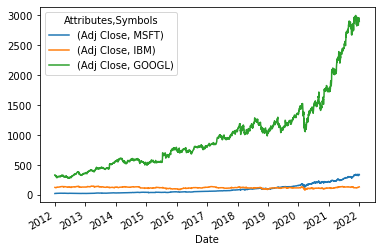

In [11]:
cols = stk_data.columns[0:3]
stk_data[cols].plot();

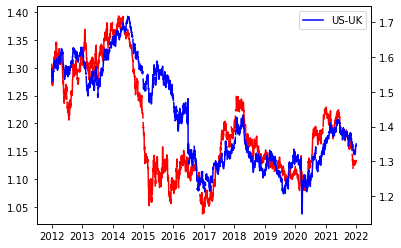

In [12]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ccy_data["USDEUR"], color='r', label="JP-US")
ax2.plot(ccy_data["GBPUSD"], color='b', label="US-UK")
plt.legend();

We can easily show the equity index data.

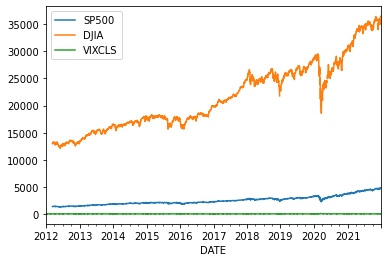

In [13]:
idx_data.plot();

### Prediction

Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

Having obtained the required data, now we can define our label series and our faetures dataframe. They will be defined as follow:

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business DayReturns    
    c. USD/JPY 5 Business DayReturns    
    d. GBP/USD 5 Business DayReturns    
    e. S&P 500 5 Business DayReturns    
    f. Dow Jones 5 Business DayReturns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We will remove the MSFT past returns when we use the Time series models.

In [14]:
msft_close = stk_data[('Adj Close', 'MSFT')] # We call the MSFT close price from the multi index matrix of stock price information

In [15]:
msft_close.tail(10)

Date
2021-12-17    323.131836
2021-12-20    319.249878
2021-12-21    326.614655
2021-12-22    332.512482
2021-12-23    333.999390
2021-12-27    341.743378
2021-12-28    340.545837
2021-12-29    341.244415
2021-12-30    338.619843
2021-12-31    335.626038
Name: (Adj Close, MSFT), dtype: float64

In [16]:
np.log(msft_close).tail(10) # We first take logs

Date
2021-12-17    5.778060
2021-12-20    5.765974
2021-12-21    5.788781
2021-12-22    5.806677
2021-12-23    5.811139
2021-12-27    5.834060
2021-12-28    5.830550
2021-12-29    5.832599
2021-12-30    5.824878
2021-12-31    5.815998
Name: (Adj Close, MSFT), dtype: float64

In [17]:
return_period = 5 # We define the holding period
Y = np.log(msft_close).diff(return_period).tail(10) # We then take differences to compute the 5-day returns
Y.tail(10)

Date
2021-12-17   -0.056262
2021-12-20   -0.059140
2021-12-21   -0.003203
2021-12-22   -0.004342
2021-12-23    0.029687
2021-12-27    0.056000
2021-12-28    0.064576
2021-12-29    0.043818
2021-12-30    0.018201
2021-12-31    0.004858
Name: (Adj Close, MSFT), dtype: float64

In [18]:
Y = np.log(msft_close).diff(return_period).shift(-return_period) # We then shift it back 5 days as we would like to now at the begining of the holding period what the return will be, this also will avoid to have a look ahead bias
Y.tail(10)
Y.dropna(inplace=True)

In [19]:
Y.name = 'MSFT_pred'

<AxesSubplot:xlabel='Date'>

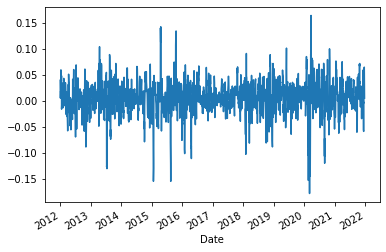

In [20]:
Y.plot()

Here, we can se the plot of the 5-days returns that we will try to predict. Now, we will create the features matrix.

In [21]:
# First, we compute the returns fro IBM and GOOGL calling the price timeseries from the mutli index matrix
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
# We remove the multi index level to have a regular dataframe
X1.columns = X1.columns.droplevel()
# We compute the returns for both the fx rates and the indexes
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)
# Finally, we form a matrix containing the lag returns. The lag period is a multiple of the holding period specified above
X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i)
                for i in [return_period, \
                          return_period*3, \
                          return_period*6, \
                          return_period*12]], axis=1).dropna()
# We rename the columns for the lagged returns matrix
X4.columns = ['MSFT_RET_DT', 'MSFT_RET_3DT', 'MSFT_RET_6DT', 'MSFT_RET_12DT']

# Finally, we merge all our built features
X = pd.concat([X1, X2, X3, X4], join = "inner", axis=1)

# We create a dataset containing all the information
dataset = pd.concat([Y, X[:-return_period]], join="inner", axis=1).dropna()

# Now extract from dataset the label column
Y = dataset.loc[:, Y.name]
# Now extract from dataset the features columns
X = dataset.loc[:, X.columns]

In [22]:
X

,GOOGL,IBM,USDEUR,GBPUSD,SP500,DJIA,VIXCLS,MSFT_RET_DT,MSFT_RET_3DT,MSFT_RET_6DT,MSFT_RET_12DT
2012-03-29,0.003646,0.013438,0.005367,0.006558,0.007511,0.007612,-0.005797,0.003743,0.003431,0.066616,0.188759
2012-03-30,-0.002103,0.015309,0.005339,0.007598,0.008098,0.009988,0.044862,0.007780,0.008404,0.030529,0.169847
2012-04-02,-0.003718,0.008149,-0.000225,0.005194,0.001784,0.001725,0.092373,-0.009248,0.007772,0.032738,0.160609
2012-04-03,-0.006824,0.011136,0.000075,-0.000376,0.000609,0.000138,0.004480,-0.017996,-0.022598,0.015778,0.134295
2012-04-04,-0.031934,-0.006000,-0.013169,0.001513,-0.004692,-0.003928,0.060815,-0.030917,-0.048775,-0.001921,0.124425
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17,-0.043334,0.026325,-0.003099,0.000528,-0.019583,-0.016978,0.143315,-0.056262,-0.017997,-0.036466,0.079639
2021-12-20,-0.029362,0.035896,0.000000,-0.000832,-0.021859,-0.020368,0.118713,-0.059140,-0.050945,-0.047422,0.068254
2021-12-21,-0.003024,0.041236,0.000444,0.002115,0.003262,-0.001449,-0.041031,-0.003203,-0.010032,-0.027379,0.108517
2021-12-22,-0.000178,0.052531,0.005579,0.009865,-0.002826,-0.004842,-0.034814,-0.004342,0.009408,-0.006392,0.163288


In [23]:
Y

2012-03-29   -0.018856
2012-03-30   -0.036620
2012-04-02   -0.058015
2012-04-03   -0.051063
2012-04-04   -0.007397
                ...   
2021-12-17    0.056000
2021-12-20    0.064576
2021-12-21    0.043818
2021-12-22    0.018201
2021-12-23    0.004858
Name: MSFT_pred, Length: 2317, dtype: float64

<a id='4'></a>
## 3. Evaluate Algorithms and Models

<a id='4.1'></a>
### 3.1. Train Test Split and Evaluation Metrics

Next, we will split our data into training and testing sets. As we will be fitting Time series models, we have to split the data in a continous fashion.

In [24]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
### 3.2. Test Options and Evaluation Metrics

In this step we will define the some parameters and the evaluation metrics that we will be using in our models trainings.

In [25]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error' 

<a id='4.3'></a>
### 3.3. Compare Models and Algorithms

In this step, we will construct and train the models to predict the MSFT 5-day return.

<a id='4.3.1'></a>
#### 3.3.1 Machine Learning models-from scikit-learn

##### Regression and Tree Regression algorithms

In [26]:
# We create a list of all the models that we will be testing in the first part of this excersice
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('MLP', MLPRegressor(hidden_layer_sizes=(100,100))))
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))

Having defined all the models, we will loop over each of them. First, running a K-fold analysis and, then, running the model on the entire training and testing dataset.

In [27]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## Here, we perform the K-Fold analysis:
    kfold = KFold(n_splits=num_folds)
    # We convert the mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Now, we perform the full training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Finally, we compute the test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000857 (0.000352) 0.000823 0.001613
LASSO: 0.000875 (0.000379) 0.000872 0.001505
KNN: 0.001049 (0.000338) 0.000520 0.001661
MLP: 0.000862 (0.000353) 0.000809 0.001543
ABR: 0.001001 (0.000344) 0.000805 0.001763
RFR: 0.000907 (0.000347) 0.000103 0.001640


The first columns represents the mean MSE resulting from the K-fold analysis, the second column is the MSE standard deviation from the same exersice, the third is the MSE of the training over the full training set and the last one is the MSE arising from the test set. As we can see, it looks like LASSO is the best performing model at predicting the MSFT 5-day return given the MSE from the validation test.

#### K Fold results

We will look more closely now to the K-Fold analysis result.

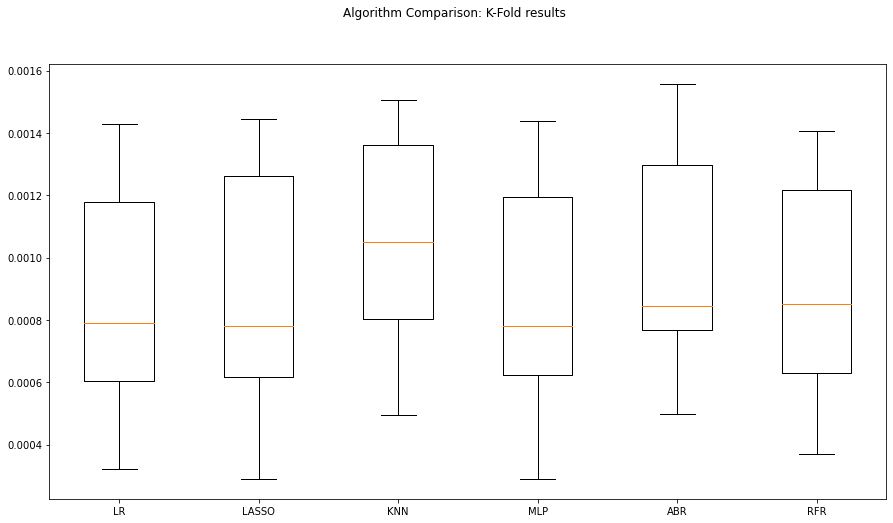

In [28]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: K-Fold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

We can see that the linear regression, the regularized regression including the Lasso regression (LASSO) and the MLP are the ones having the lower MSE even if the variance of such a measure seems to be slightly bigger that one observed in the other models.

Now, let us compare the MSE in the train and test errors in a more graphical way.

#### Training and Test error

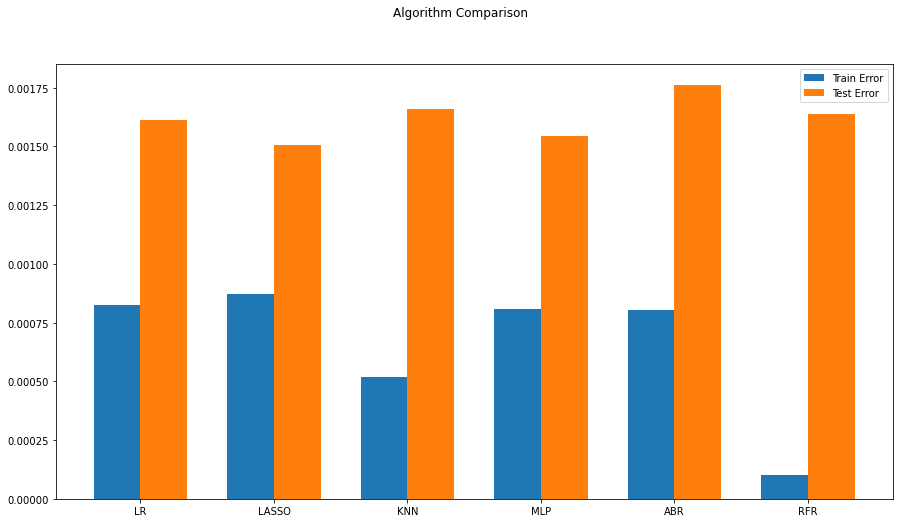

In [29]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at this graph, we can see that the MSE on the test set seems pretty consisten along models, but it is not the case regarding the training set. This suggest that some models, specially the Random Forest one, have overfitted the training set. The linear regresion model, the LASSO, and the MLP models seem to be more consistent concerning the train error and test error. 

<a id='4'></a>
## 4.Multilayer Percepton model analysis

Now, we will realized a more in depth comparison of the above models with the  Tensor Flow Multilayer Neural Networks. In such analysis, we will vary the number of hidden layers and the number of neurons per layer to have a deeper understanding of the model performance.

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from itertools import product

In [35]:
res_list = []

# We will loop over the number of layers, the number of neurons and different activation functions

for lrs, nrn, act_func in product([1,2,3], [10, 50, 100], ['relu', 'tanh', 'softmax', None]): # act. function and init. from p. 334 Geron
    model = Sequential()
    model.add(Input(shape=11,)) # The input shape corresponds to the number of features
    # Here we add the corresponding number of hidden layers
    for i in range(0,lrs): 
        # Here, we will choose a different weighting initializer depending on the activation function
        if act_func == 'relu': 
            model.add(Dense(nrn, activation=act_func, kernel_initializer="he_normal"))
        #elif act_func == 'selu':
        #    model.add(Dense(nrn, activation=act_func, kernel_initializer="lecun_normal"))
        else:
            model.add(Dense(nrn, activation=act_func, kernel_initializer="glorot_normal"))
    # Here, we add the output layer
    model.add(Dense(1))
    # Here, we compile the specified model
    model.compile(optimizer='adam',
            loss='mse',
            metrics=['mse'])
    # We fit the model
    model.fit(X_train, Y_train)
    
    # We create a dataframe storing the MSE of both the train and the test sets
    res_list.append([act_func, lrs, nrn, \
        model.evaluate(X_train, Y_train)[0], \
        model.evaluate(X_test, Y_test)[0]])

resutls_df = pd.DataFrame(res_list, columns=['Activation', 'Layers', 'Neurons', 'MSE Train', 'MSE Test'])

15/15 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016


In [36]:
# Here, we sort the models to get the 10 with the lowest MSE on testing sample
resutls_df.sort_values('MSE Test', ascending = True).head(10)

,Activation,Layers,Neurons,MSE Train,MSE Test
21,tanh,2,100,0.000886,0.001444
22,softmax,2,100,0.000881,0.001495
18,softmax,2,50,0.000875,0.001497
10,softmax,1,100,0.000866,0.001498
34,softmax,3,100,0.000873,0.001503
30,softmax,3,50,0.000873,0.001503
26,softmax,3,10,0.000873,0.001503
14,softmax,2,10,0.000872,0.001512
6,softmax,1,50,0.000871,0.001520
1,tanh,1,10,0.000873,0.001545


At this point we can take three best models and compare them with the SKlearn models:
- Tanh-Geron Init., 2 layers, 100 neurons
- Softmax-Geron Init., 2 layers, 100 neurons
- Softmax-Geron Init., 2 layers, 50 neurons

#### Training and Test error

In [37]:
# Here, we will create a dataframe containing the results of the top 3 performing models

names_ann, train_ann, test_ann = [], [], []

for i in ['Tnh 2 100', 'SMx 2 100', 'SMx 2 50']:
    names_ann.append(i)

for i in [21, 22, 18]: # We pass the index of the best pefroming models, which can be seen in the dataframe obtained above
    train_ann.append(resutls_df.iloc[i,3])
    test_ann.append(resutls_df.iloc[i,4])
    
for i, j, k in zip(names_ann, train_ann, test_ann):
    names.append(i)
    train_results.append(j)
    test_results.append(k)

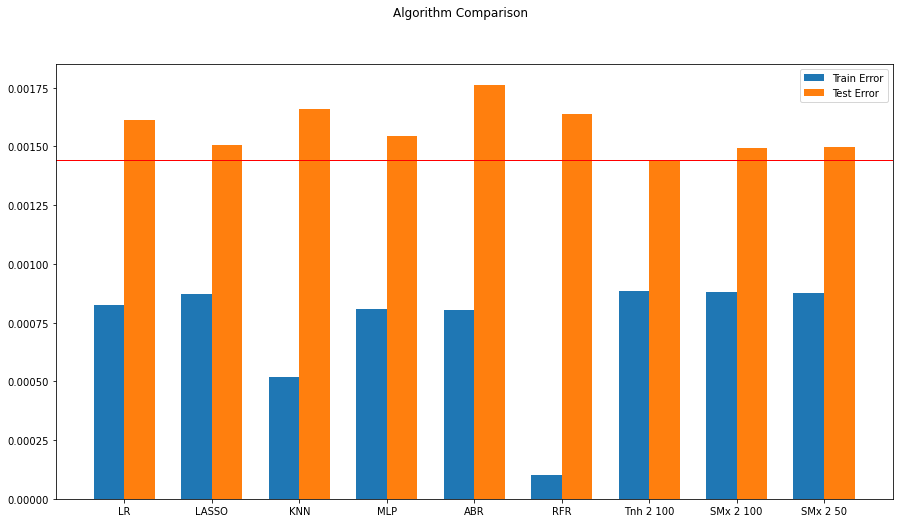

In [38]:
# We will modify the plot comparing the models that we built in the first part of the question
# by adding the new top three performes we got.
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
pyplot.axhline(y=min(test_results),linewidth=1, color='r')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

On the barchart we can see that the ANNs outperform every SKlearn method using as a benchmark the models' MSE, as an accuracy score. LASSO regression is a close contender, but the ANNs are better by a narrow margin. Even though training error of the ANNs is higher than that of every other SKlearn method. It is important mention the best perfomer ANNs choice will change each time we run the loop. Nonetheless, the train and test error obtained at each trial we made were very consistent.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# QUESTION 2

## Deep Learning Black Scholes using TensorFlow
The goal of this case study is to perform derivative pricing from a machine learning standpoint of view by training a supervised regression-based model to learn the Black-Scholes option pricing model from simulated data.


<a id='0'></a>
## 1. Problem Definition

In this question, we will be trying to train an Artificial Neural Network based on a linear regression model under a supervised learning framework to predict the price from a call options based on some market inputs. To perform this we will generate a series of inputs such as:

- Monenyess defined as $\frac{K}{S}$
- Time to maturity
- Volatiltiy

We will be using the Black and Scholes formula to derive the price of the option, which then we will specify as our label, while the inputs described above will be our features. The Black and Scholes formula for the price of a call option is defined as:

$$  Se^{-q \tau}\Phi(d_1) - e^{-r \tau} K\Phi(d_2) \, $$

Where:

$$  d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)\tau}{\sigma\sqrt{\tau}}  $$

and


$$  d_2 = \frac{\ln(S/K) + (r - q - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} = d_1 - \sigma\sqrt{\tau}  $$


Where we have:

- Stock price -> $S$
- Strike price -> $K$
- Risk-free rate -> $r$ (we will set this to 2.0%)
- Annual dividend yield -> $q$ (we will set this to 0 to make our analysis more easy to interpret)
- Time to maturity -> $\tau = T-t$ (represented as a unit-less fraction of one year)
- Volatility $\sigma$

As we will be using moneyness, as defined above, to feed the formula. The modified version of the option price that we will be using is:

$$  S e^{-q \tau}\Phi\left( \frac{- \ln(M) + (r+ \sigma^2/2 )\tau}{\sigma\sqrt{\tau}}\right) - S e^{-r \tau} M\Phi\left( \frac{- \ln(M) + (r - \sigma^2/2)\tau}{\sigma\sqrt{\tau}} \right) \, $$


### Python Imports

In [39]:
# Distribution functions
from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix

# Random Seed
np.random.seed(13)

In [40]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
### 2.2. Defining functions and parameters

#### Vol and Option Pricing Functions

In [41]:
def call_option_price(s0, M, t, v):
    
    d1=(-np.log(M)+(r+np.square(v)/2)*t)/(v*np.sqrt(t))
    d2=(-np.log(M)+(r-np.square(v)/2)*t)/(v*np.sqrt(t))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    return s0 * N_d1 - s0 * M * np.exp(-r*t) * N_d2

In [42]:
r = 0.02
s0 = 100.0
N = 10000

## Start Coursework Here

In this step we will generate 10,000 option prices for a range of K, T, sigma holding r fixed based on the B&S pricing formula definded above.

In [43]:
Ms = np.array((0.5+1.0*np.random.random(N)))
Vs = np.array(np.random.uniform(0.1, 0.5, N)) # add randomness to the volatility
Vs2 =  Vs.copy() # we already create a copy of volatility array for the delta calculation
Ts = np.array(np.random.random(N)) * 5.0
Ts2 =  Ts.copy() # we already create a copy of time array for the delta calculation

Ps = np.array([call_option_price(100/m, m, t, v) for m, t, v in zip(Ms,Ts,Vs)])

In [44]:
# organizing and vizualizing the dataset
Y = Ps.copy()
X = np.concatenate([Ms.reshape(-1,1), Ts.reshape(-1,1),Vs.reshape(-1,1)],axis=1)

dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Volatility'])

In [45]:
dataset

,Price,Moneyness,Time,Volatility
0,3.735972,1.277702,1.789969,0.224770
1,39.675734,0.737541,1.231403,0.242953
2,3.653933,1.324279,4.027271,0.147598
3,0.806695,1.465749,1.784467,0.189859
4,0.549242,1.472601,1.667874,0.181977
...,...,...,...,...
9995,5.195986,1.296672,0.701826,0.456636
9996,1.048266,1.073503,0.457678,0.122301
9997,63.447906,0.632526,1.044442,0.411851
9998,4.481944,1.298178,0.587229,0.468628


In [46]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.precision', 3)
dataset.describe()

,Price,Moneyness,Time,Volatility
count,10000.000,10000.000,10000.000,10000.000
mean,30.653,1.004,2.500,0.300
std,28.202,0.289,1.446,0.116
min,0.000,0.500,0.000,0.100
25%,7.971,0.750,1.241,0.199
50%,21.738,1.008,2.488,0.301
75%,46.626,1.254,3.760,0.400
max,125.336,1.500,5.000,0.500


### 3.2. Data Visualization

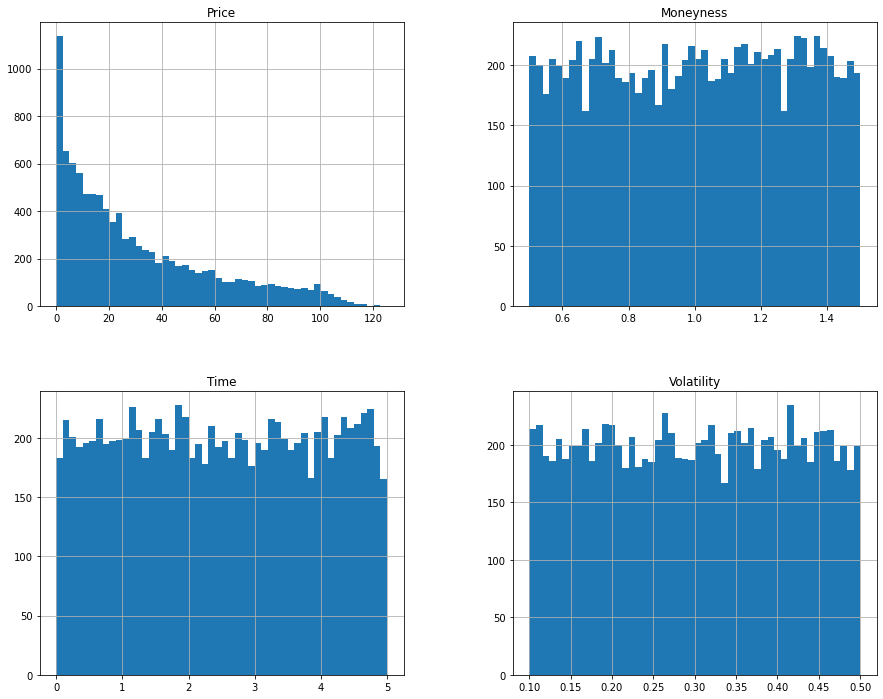

In [47]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=10, ylabelsize=10, figsize=(15,12));

We can see that the price has an interesting distribution with a spike at $0$ due to all of the OTM options. We can clearly observe that Volatility is randomly distributed, just as Time and Moneyness.

### 3.3 Features Importance

In [48]:
bestfeatures = SelectKBest(k='all', score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(['Moneyness', 'Time', 'Volatility'])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Moneyness,33258.007
Time,425.897
Volatility,303.830


As we can observe from the Feature Importance scores, Time and Volatility have roughly the same level of importance to predict the variables, which is low, while Moneyness carries higher predictive power.

## 4. Evaluating Models and Parameters

### 4.1. Train Test Split

In this step, we will create split the data between train and test datasets, in a 75%-25% propotion, accordingly.

In [49]:
dataset

,Price,Moneyness,Time,Volatility
0,3.736,1.278,1.790,0.225
1,39.676,0.738,1.231,0.243
2,3.654,1.324,4.027,0.148
3,0.807,1.466,1.784,0.190
4,0.549,1.473,1.668,0.182
...,...,...,...,...
9995,5.196,1.297,0.702,0.457
9996,1.048,1.074,0.458,0.122
9997,63.448,0.633,1.044,0.412
9998,4.482,1.298,0.587,0.469


In [50]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,1:], 
                                                              dataset.iloc[:,0],
                                                              random_state=42)

In [51]:
X_test.applymap('{:,.6f}'.format)

,Moneyness,Time,Volatility
6252,1.164093,4.586722,0.489577
4684,0.950294,4.648455,0.326453
1731,1.476376,3.682006,0.223627
4742,0.744891,0.696709,0.456017
4521,1.448923,2.488680,0.178372
...,...,...,...
4862,0.966597,4.599176,0.278848
7025,0.695171,3.136357,0.176345
7647,0.589599,1.435388,0.410615
7161,0.567470,2.429784,0.489693


### 4.2. Setting up a Neural Network model using Keras

We start by seting up a training function that allows us to loop through the number of hidden layers and nodes. This will be usefull in the future when we need to find the optimal architecture.

In [52]:
# We set up the learning rate at 0.001 and the standard optimizer as Adam
# Further down in our analysis we will test for the best optimizer

learning_rate=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

def train_model(hidden_layers, nodes, optimizer=optimizer):
    model = Sequential()
    
    
    model.add(Input(shape=X_train.shape[1:])) # We have 3 nodes in the input layer, one for each parameter in X

    for x in range(0, hidden_layers):
        model.add(Dense(nodes, activation='relu')) # We use 'relu' activation function to avoid zero gradients with extreme inputs
        #model.add(Dropout(0.20))  # After a couple of tests, we conclude that adding dropout doesnt add much value to the model
    
    model.add(Dense(1)) # the final layer doesn't need no activation function since this is a linear regression model

    model.compile(loss='mean_squared_error', optimizer = optimizer) # We use MSE as loss function since this is a linear regression model
    
    return model

In [53]:
# Model summary
train_model(hidden_layers=1, nodes=50).summary()

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_324 (Dense)           (None, 50)                200       
                                                                 
 dense_325 (Dense)           (None, 1)                 51        
                                                                 
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Fitting the model using random values for hidden layers and nodes. We will tune this parameters further down in our analysis

g = train_model(hidden_layers=3, nodes=50).fit(X_train, y_train, epochs=100, batch_size=200, validation_data=(X_test, y_test))

Epoch 1/100
38/38 [==============================] - 1s 9ms/step - loss: 1612.3470 - val_loss: 1407.6915
Epoch 2/100
38/38 [==============================] - 0s 3ms/step - loss: 1075.3428 - val_loss: 835.3234
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 828.4147 - val_loss: 777.5312
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 762.2482 - val_loss: 699.2349
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 652.7448 - val_loss: 552.1799
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 453.0972 - val_loss: 308.3315
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 210.2072 - val_loss: 133.9870
Epoch 8/100
38/38 [==============================] - 0s 3ms/step - loss: 105.2312 - val_loss: 85.8238
Epoch 9/100
38/38 [==============================] - 0s 3ms/step - loss: 70.3746 - val_loss: 60.8526
Epoch 10/100
38/38 [==============================] - 0s 3ms/step - loss:

In [55]:
final_loss_adam = g.history['loss'][-1]
final_val_loss_adam = g.history['val_loss'][-1]

In [56]:
final_val_loss_adam

0.11989369988441467

### 4.3. Evaluating Results

First, we look at the Loss x Epochs graphic to analyse the efficiency gain in our model

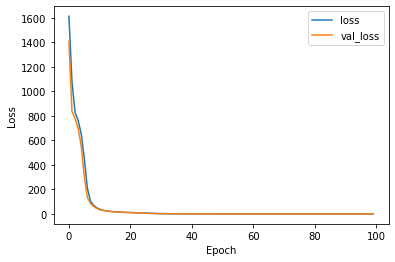

In [57]:
plt.plot(g.history['loss'], label='loss')
plt.plot(g.history['val_loss'], label='val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

As can be observed in the Loss x Epoch graph above, the loss in the model are decreasing smoothly as we increase the number of Epochs, which is a good sign.

Now, we create a Predicted x Actual price graph to have a visual on how well is our model predicting the label

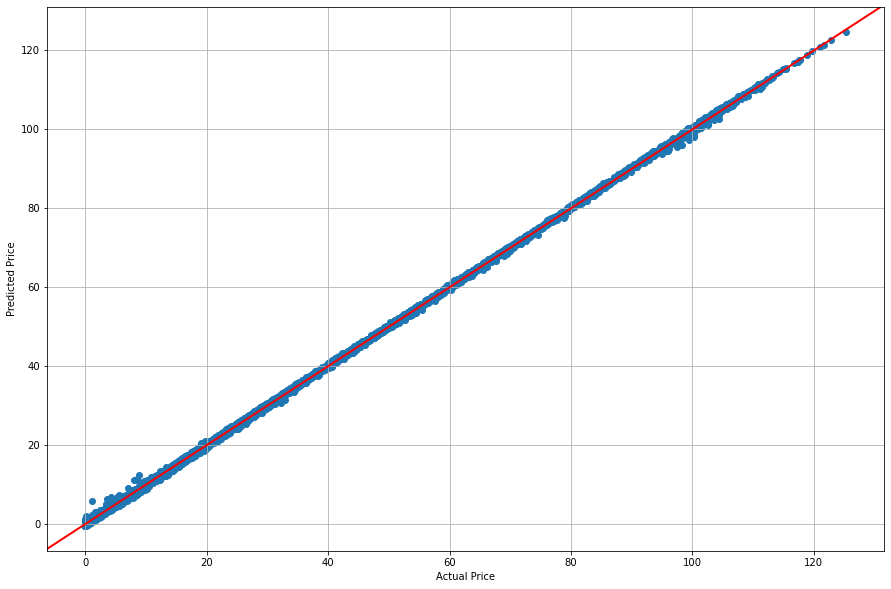

In [58]:
predictions = g.model.predict(X)
plt.figure(figsize = (15,10))
plt.scatter(Y, predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.axline((15,15), (18, 18), linewidth=2, color='r')
plt.grid(True)

This graph visualy shows us how good the model is predicting the option prices on the whole dataset. We expect this to improve as we tune our hyprparameters.

### 4.4. Choosing best optimizer

Now, before moving on to the analysis of the neural network structure, let's see if we can get better results using Rmsprop instead of Adam

In [59]:
g_2 = train_model(hidden_layers=3, nodes=50, optimizer='rmsprop').fit(X_train, y_train, epochs=100, batch_size=200,validation_data=(X_test, y_test))

Epoch 1/100
38/38 [==============================] - 1s 7ms/step - loss: 1443.2822 - val_loss: 1077.4614
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 903.3603 - val_loss: 817.0975
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 814.1617 - val_loss: 768.7103
Epoch 4/100
38/38 [==============================] - 0s 3ms/step - loss: 762.3303 - val_loss: 708.8389
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 679.3926 - val_loss: 602.9399
Epoch 6/100
38/38 [==============================] - 0s 3ms/step - loss: 534.5238 - val_loss: 433.3588
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 345.1392 - val_loss: 258.3492
Epoch 8/100
38/38 [==============================] - 0s 3ms/step - loss: 185.3202 - val_loss: 132.6767
Epoch 9/100
38/38 [==============================] - 0s 3ms/step - loss: 105.5046 - val_loss: 97.1567
Epoch 10/100
38/38 [==============================] - 0s 3ms/step - loss

In [60]:
final_loss_rms = g_2.history['loss'][-1]
final_val_loss_rms = g_2.history['val_loss'][-1]

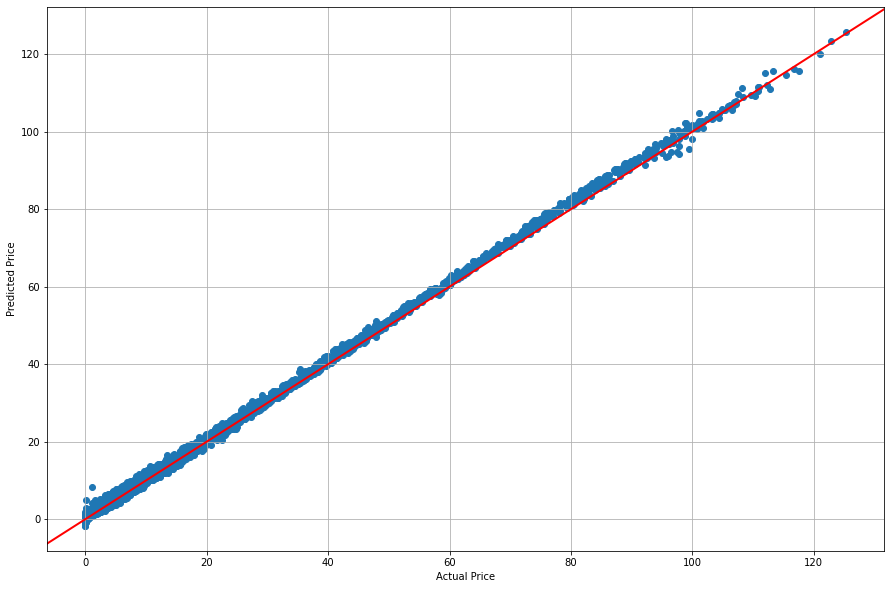

In [61]:
predictions_2 = g_2.model.predict(X_test)
plt.figure(figsize = (15,10))
plt.scatter(y_test, predictions_2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.axline((16,16), (18, 18), linewidth=2, color='r')
plt.grid(True)

In [62]:
opt_compare = pd.DataFrame(data=[[final_val_loss_adam, final_val_loss_rms]], columns = ['Adam', 'RmsProp'])
opt_compare

,Adam,RmsProp
0,0.120,1.583


We can observe that the final validation loss using Adam is better, and the Prediction x Actual graph using Adam also looks better, so we will stick to that optimizer from now on.

### 4.5. Analysing Neural Network structure

To better understand and find the most adequate Neural Network structure for this model, we will retrain it with varying values for hidden layers and number of neurons per layer. We'll be using the following parameters:

* Inputs:
    * Hidden layers: [1,2,3,4]
    * Neurons: [10,20,50,100]


* Outputs:
    * 16 different NN models, containing:
        * Final loss
        * Final val loss

First, we loop through the inputs and store the results in a dataframe:

In [63]:
results_df = pd.DataFrame(columns=['Hidden layers', 'Nodes', 'Val Loss'])

for i in [1, 2, 3, 4]:
    for x in [10, 20, 50, 100]:
        nn = train_model(hidden_layers=i, nodes = x, optimizer=optimizer).fit(X_train, y_train, epochs=100, batch_size = 200, verbose=1, validation_data=(X_test, y_test))
        L = [i, x, nn.history['val_loss'][-1]]
        results_df.loc[len(results_df)] = L

# We decided to maintain the standard verbose = 1 in this loop so we can observe how val_loss goes down as the number of epochs increases in each structure

Epoch 1/100
38/38 [==============================] - 1s 6ms/step - loss: 1637.0741 - val_loss: 1483.7454
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 1346.9528 - val_loss: 1207.0513
Epoch 3/100
38/38 [==============================] - 0s 3ms/step - loss: 1111.0620 - val_loss: 1015.3740
Epoch 4/100
38/38 [==============================] - 0s 3ms/step - loss: 964.3052 - val_loss: 907.4503
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 889.3553 - val_loss: 857.0363
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 856.1061 - val_loss: 832.8882
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 840.7274 - val_loss: 820.7795
Epoch 8/100
38/38 [==============================] - 0s 3ms/step - loss: 831.5201 - val_loss: 811.9197
Epoch 9/100
38/38 [==============================] - 0s 3ms/step - loss: 823.8521 - val_loss: 804.2603
Epoch 10/100
38/38 [==============================] - 0s 3ms/step -

In [64]:
results_df

,Hidden layers,Nodes,Val Loss
0,1.000,10.000,112.813
1,1.000,20.000,80.270
2,1.000,50.000,27.890
3,1.000,100.000,20.013
4,2.000,10.000,8.996
5,2.000,20.000,3.886
6,2.000,50.000,0.461
7,2.000,100.000,0.408
8,3.000,10.000,2.075
9,3.000,20.000,2.664


Now, we find the architechture with the least Loss value

In [65]:
best_arch = results_df.sort_values('Val Loss').iloc[0]
best_arch

Hidden layers     4.000
Nodes           100.000
Val Loss          0.073
Name: 15, dtype: float64

Now, that we found that 4 Hidden Layers and 100 Neurons is the best strucutre for this model, we will fit it with the name 'nn'. This will be the model used to predict values throughout the rest of the exercise.

In [67]:
nn = train_model(hidden_layers=4, nodes = 100, optimizer=optimizer).fit(X_train, y_train, epochs=100, batch_size = 200, validation_data=(X_test, y_test))

Epoch 1/100
38/38 [==============================] - 1s 11ms/step - loss: 934.5395 - val_loss: 550.2719
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 189.5497 - val_loss: 47.1257
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 26.5750 - val_loss: 16.6240
Epoch 4/100
38/38 [==============================] - 0s 5ms/step - loss: 13.7944 - val_loss: 10.9474
Epoch 5/100
38/38 [==============================] - 0s 6ms/step - loss: 9.5667 - val_loss: 7.5411
Epoch 6/100
38/38 [==============================] - 0s 6ms/step - loss: 6.5796 - val_loss: 5.2548
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - loss: 4.1794 - val_loss: 3.0180
Epoch 8/100
38/38 [==============================] - 0s 5ms/step - loss: 2.6840 - val_loss: 1.8856
Epoch 9/100
38/38 [==============================] - 0s 5ms/step - loss: 1.5587 - val_loss: 1.2607
Epoch 10/100
38/38 [==============================] - 0s 5ms/step - loss: 1.0864 - val_loss: 0.94

Now, let's take a look at the Predicted x Actual option prices graph with our optimized structure.

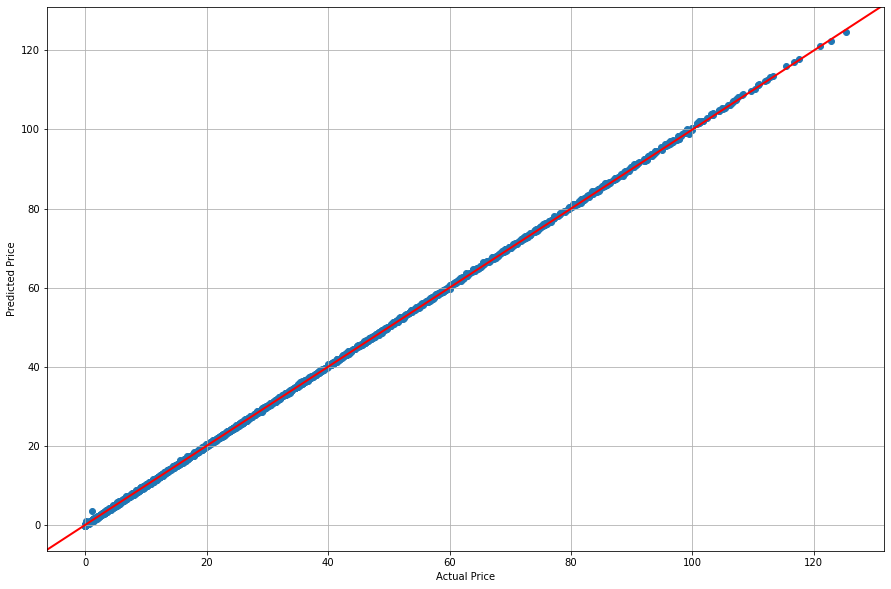

In [68]:
predictions_2 = nn.model.predict(X_test)
plt.figure(figsize = (15,10))
plt.scatter(y_test, predictions_2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.axline((0,0), (17.5, 17.5), linewidth=2, color='r')
plt.grid(True)

We can clearly observe improvements in comparision to the first Predicted x Actual option prices graph. This illustrates the improvement in the validation loss after optimization: We started with val_loss of 0.12 using Adam with random parameters in the first training and now we have 0.0593.

## 5. Calculating and Analysing delta in the optimal architechture

### 5.1 Black Scholes Call Option function

For this part of the question, we will calculate Delta using the Black-Scholes equation in the training and test examples.

$$\Delta C=\mathrm{e}^{-qt}N(d1)$$

In [69]:
# Defining the call_delta function
def call_delta(M, t, v, q):
    # Black Scholes Equation
    d1=(-np.log(M)+(r+np.square(v)/2)*t)/(v*np.sqrt(t))
    N_d1 = norm.cdf(d1)
    return np.exp(-q*t) * N_d1

In [70]:
# Testing the new function
call_delta(0.79906977, 3.76447894, 0.2489582, 0)

0.805588857405409

In [71]:
# Here, we create a vector for the call deltas for each of our observed market inputs
delta_BS = np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms,Ts,Vs)])

In [72]:
delta_BS

array([0.2926984 , 0.9123468 , 0.29867905, ..., 0.91121853, 0.30347908,
       0.80558886])

### 5.2 Generating deltas from the Neural Network model using the approxiamtion function

Now, we will calculate Delta using our trained Neural Network model. To do this, we will calculate the new call price P' considering a 0.01 variation in stock price, which is equivalent to a 0.0001 variation in moneyness, which means that $S_{0}^{'}=S_{0}+0.01$ and $K=100$. With that value we are able to calculate Delta by applying:

$$\Delta C=(P'-P) / 0.01$$

To account for the 0.0001 change in Moneyness we will use the following equation:

$$Ms2=\frac{K}{\frac{K}{Ms}+0.01}$$

With Moneyness (Ms) defined as:

$$Ms=\frac{K}{S}$$

In [73]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [74]:
# Creating new dataset with new moneyness values

dataset_new = pd.DataFrame(dataset, columns=['Moneyness','Time','Volatility'])
Ms2=1/((((1/Ms)*100)+0.01)/100)
X_new = np.concatenate([Ms2.reshape(-1,1), Ts2.reshape(-1,1),Vs2.reshape(-1,1)],axis=1) # Ts2 and Vs2 are simple copies from previous Ts and Vs
Ps2 = np.array([call_option_price(100/m, m, t, v) for m, t, v in zip(Ms2,Ts2,Vs2)])
dataset_new = pd.DataFrame(data=np.concatenate((Ps2.reshape(-1,1),X_new),axis=1), columns=['Price,','Moneyness','Time','Volatility'])
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(dataset_new.iloc[:,1:], 
                                                              dataset_new.iloc[:,0],
                                                              random_state=42)

Now that we have our dataset with new moneyness, we can predict prices using our previously trained Neural Network model called 'nn'.
We will predict prices:

- before and after the price variation
- in and out of sample

Therefore, we will have 4 diferent predicted prices.

In [75]:
# yhat_1_IS = In sample predicted values before price variation
# yhat_1_OS = Out of sample predicted values before price vatiation

# yhat_2_IS = In sample predicted values after price variation
# yhat_2_OS = Out of sample predicted values after price variation


yhat_1_IS = nn.model.predict(X_train)
yhat_1_OS = nn.model.predict(X_test)

yhat_2_IS = nn.model.predict(X_train_new)
yhat_2_OS = nn.model.predict(X_test_new)

Now that we have the new option prices (predicted and actual), we calculate Delta using the previously defined approximation equation.

We calculate delta:

- using predicted and actual prices
- in and out of sample

Therefore, we will have 4 different deltas.

In [76]:
# delta_1_IS = In sample Delta using predicted prices from NN
# delta_1_OS = Out of sample Delta using predicted prices from NN

# delta_2_IS = In sample Delta using actual prices from dataset
# delta_2_OS = Out of sample Delta using actual prices from dataset

delta_1_IS = (yhat_2_IS - yhat_1_IS) / 0.01
delta_1_OS = (yhat_2_OS - yhat_1_OS) / 0.01

delta_2_IS = (np.array(y_train_new) - np.array(y_train)) / 0.01
delta_2_OS = (np.array(y_test_new) - np.array(y_test)) / 0.01

Now we calculate deltas using the BS pricing function.

We calculate BS deltas:

- in and out of sample

Therefore, we will have 2 different BS deltas

In [77]:
# BS Deltas in and out of sample

Ms_d_OS=dataset.iloc[y_test.index,:]['Moneyness']
Ts_d_OS=dataset.iloc[y_test.index,:]['Time']
Vs_d_OS=dataset.iloc[y_test.index,:]['Volatility']

delta_BS_OS = np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms_d_OS,Ts_d_OS,Vs_d_OS)])

Ms_d_IS=dataset.iloc[y_train.index,:]['Moneyness']
Ts_d_IS=dataset.iloc[y_train.index,:]['Time']
Vs_d_IS=dataset.iloc[y_train.index,:]['Volatility']

delta_BS_IS = np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms_d_IS,Ts_d_IS,Vs_d_IS)])


# Moneyness after price shock
Ms_n_IS = X_train_new['Moneyness']
Ms_n_OS = X_test_new['Moneyness']

### 5.3 Analysing Neural Network model delta

Now, that we have all deltas and prices, we will start our analysis.

The first step is to create two comparison DataFrames containing all the information we need, one for in sample analysis and another for out of sample analysis.

In [78]:
# Comparison In Sample

comparison_IS = pd.DataFrame(data=yhat_2_IS.reshape(-1,1), columns=['yhat_2_IS'])
comparison_IS['yhat_1_IS'] = pd.DataFrame(yhat_1_IS.reshape(-1,1))
comparison_IS['delta_1_IS'] = pd.DataFrame(delta_1_IS.reshape(-1,1))
comparison_IS['y_2_IS'] = pd.DataFrame(np.array(y_train_new).reshape(-1,1))
comparison_IS['y_1_IS'] = pd.DataFrame(np.array(y_train).reshape(-1,1))
comparison_IS['delta_2_IS'] = pd.DataFrame(delta_2_IS.reshape(-1,1))
comparison_IS['delta_BS_IS'] = pd.DataFrame(delta_BS_IS.reshape(-1,1))
comparison_IS['Ms_2_IS'] = pd.DataFrame(Ms_n_IS.values)
comparison_IS['Ms_1_IS'] = pd.DataFrame(Ms_d_IS.values)
comparison_IS['Ts_IS'] = pd.DataFrame(Ts_d_IS.values)
comparison_IS['Vs_IS'] = pd.DataFrame(Vs_d_IS.values)

comparison_IS

,yhat_2_IS,yhat_1_IS,delta_1_IS,y_2_IS,y_1_IS,delta_2_IS,delta_BS_IS,Ms_2_IS,Ms_1_IS,Ts_IS,Vs_IS
0,52.9560,52.9471,0.8884,52.9146,52.9062,0.8431,0.8431,0.7081,0.7082,2.0375,0.3604
1,9.2348,9.2299,0.4901,9.2245,9.2203,0.4212,0.4211,1.4319,1.4321,3.6832,0.3034
2,17.2057,17.1988,0.6874,17.4729,17.4663,0.6651,0.6650,0.9287,0.9288,0.4999,0.4365
3,8.4014,8.3969,0.4469,8.3163,8.3119,0.4413,0.4413,1.2621,1.2622,4.7975,0.1808
4,31.2331,31.2267,0.6420,31.1399,31.1332,0.6672,0.6672,1.1559,1.1561,4.1783,0.4836
...,...,...,...,...,...,...,...,...,...,...,...
7495,11.3598,11.3551,0.4729,11.3147,11.3100,0.4631,0.4631,1.3318,1.3319,3.1565,0.3277
7496,80.2971,80.2875,0.9567,80.1365,80.1267,0.9773,0.9773,0.5622,0.5622,0.8625,0.3470
7497,73.9336,73.9234,1.0193,73.5406,73.5306,1.0000,1.0000,0.5841,0.5841,1.1843,0.1342
7498,6.4313,6.4265,0.4825,6.4038,6.3991,0.4631,0.4630,1.1607,1.1608,4.8861,0.1090


In [79]:
# Comparison Out of Sample

comparison_OS = pd.DataFrame(data=yhat_2_OS.reshape(-1,1), columns=['yhat_2_OS'])
comparison_OS['yhat_1_OS'] = pd.DataFrame(yhat_1_OS.reshape(-1,1))
comparison_OS['delta_1_OS'] = pd.DataFrame(delta_1_OS.reshape(-1,1))
comparison_OS['y_2_OS'] = pd.DataFrame(np.array(y_test_new).reshape(-1,1))
comparison_OS['y_1_OS'] = pd.DataFrame(np.array(y_test).reshape(-1,1))
comparison_OS['delta_2_OS'] = pd.DataFrame(delta_2_OS.reshape(-1,1))
comparison_OS['delta_BS_OS'] = pd.DataFrame(delta_BS_OS.reshape(-1,1))
comparison_OS['Ms_2_OS'] = pd.DataFrame(Ms_n_OS.values)
comparison_OS['Ms_1_OS'] = pd.DataFrame(Ms_d_OS.values)
comparison_OS['Ts_OS'] = pd.DataFrame(Ts_d_OS.values)
comparison_OS['Vs_OS'] = pd.DataFrame(Vs_d_OS.values)

comparison_OS

,yhat_2_OS,yhat_1_OS,delta_1_OS,y_2_OS,y_1_OS,delta_2_OS,delta_BS_OS,Ms_2_OS,Ms_1_OS,Ts_OS,Vs_OS
0,33.0858,33.0792,0.6622,32.8132,32.8064,0.6797,0.6797,1.1640,1.1641,4.5867,0.4896
1,34.8836,34.8758,0.7828,34.6088,34.6017,0.7111,0.7110,0.9502,0.9503,4.6485,0.3265
2,4.4713,4.4677,0.3597,4.5145,4.5115,0.3010,0.3009,1.4762,1.4764,3.6820,0.2236
3,40.7593,40.7507,0.8591,40.7541,40.7456,0.8415,0.8415,0.7448,0.7449,0.6967,0.4560
4,1.5208,1.5188,0.1902,1.4343,1.4328,0.1587,0.1586,1.4487,1.4489,2.4887,0.1784
...,...,...,...,...,...,...,...,...,...,...,...
2495,29.7683,29.7614,0.6918,29.4984,29.4915,0.6949,0.6948,0.9665,0.9666,4.5992,0.2788
2496,51.7903,51.7807,0.9628,51.3633,51.3540,0.9359,0.9359,0.6951,0.6952,3.1364,0.1763
2497,76.7906,76.7813,0.9300,76.4298,76.4207,0.9159,0.9159,0.5896,0.5896,1.4354,0.4106
2498,92.4310,92.4221,0.8957,92.2438,92.2349,0.8825,0.8825,0.5674,0.5675,2.4298,0.4897


Now, we will create Comparison Graphs between the NN Delta and the BS Deltas, both In sample and Out of sample.

This will give us a visual perspective on how well our model is predicting deltas in comparision to the actual Black Scholes deltas.

Text(0.5, 1.0, 'Out of Sample - NN Delta approx x BS Delta')

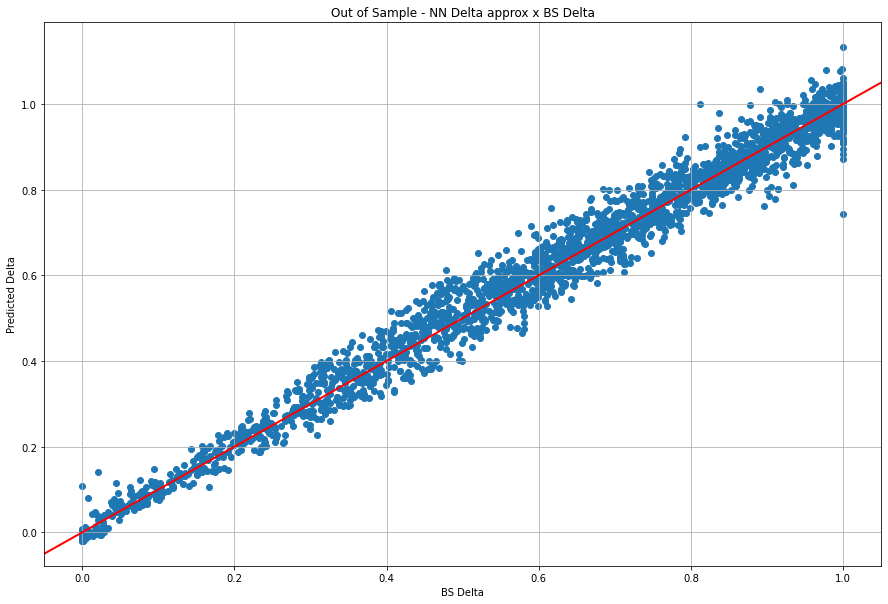

In [80]:
# Out of Sample
plt.figure(figsize = (15,10))
plt.scatter(delta_BS_OS,delta_1_OS)
plt.xlabel("BS Delta")
plt.ylabel("Predicted Delta")
plt.axline((0,0), (1, 1), linewidth=2, color='r')
plt.grid(True)
plt.title('Out of Sample - NN Delta approx x BS Delta')

Text(0.5, 1.0, 'In Sample - NN Delta approx x BS Delta')

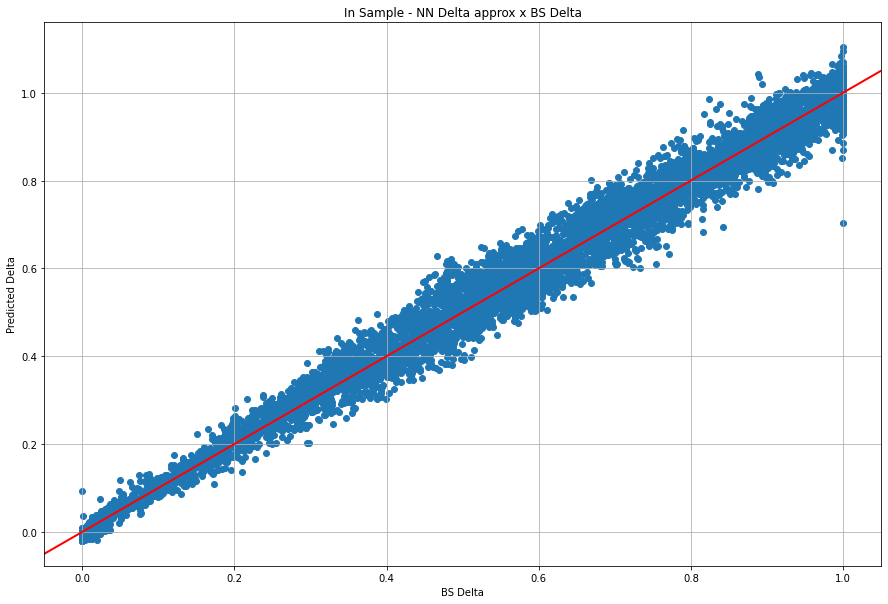

In [81]:
# In Sample
plt.figure(figsize = (15,10))
plt.scatter(delta_BS_IS,delta_1_IS)
plt.xlabel("BS Delta")
plt.ylabel("Predicted Delta")
plt.axline((0,0), (1, 1), linewidth=2, color='r')
plt.grid(True)
plt.title('In Sample - NN Delta approx x BS Delta')

As can be observed from the In sample and Out of sample deltas comparision, the model is predicting the deltas reasonably well.

The prediction error in Deltas is clearly higher than that of the Option Prices. This happens because of a multiplication effect of the pricing error in the approximation function of delta.

$$\Delta C=(P'-P) / 0.01$$

When we use the above formula, all errors that occur in the price prediction model are divided by 0.01, which has the same effect as to multiplying by 100.

### 5.4 Plotting Delta x Moneyness and Delta x Volatility for the 16 previously defined architectures 

In this step we will create graphs comparing our predicted Deltas against Volatility and Moneyness.

We will use all 16 previously defined architectures and organize them in graphs together with Black Scholes deltas.

To begin, we will calculate 4 new datasets:

- Two with varying values for Moneyness, with fixed Volatility and Time.
    - One with standard prices (name: X_test_g1)
    - One with prices increased by 0.01 (name: X_test_g1_s)
- Two with varying values for Volatility, with fixed Moneyness and Time
    - One with standard prices (name: X_test_g2)
    - One with prices increased by 0.01 (name: X_test_g2_s)
    
    
In this section we will also calculate 2 new Black Scholes deltas using the new datasets:

- One using the dataset with varying Moneyness (name: delta_g1)
- One using the dataset with varying Volatility (name: delta_g2)

In [82]:
# Creating empty dataframes for storying delta values
deltas_g1 = pd.DataFrame(index=range(0,250), columns=['1x10', '1x20', '1x50', '1x100', '2x10', '2x20', '2x50', '2x100', 
                                                   '3x10', '3x20', '3x50', '3x100', '4x10', '4x20', '4x50', '4x100'])
deltas_g2 = deltas_g1.copy()

# Moneyness varies, time and volatility fixed
Ms_g1 = np.array((0.5+1.0*np.random.random(250)))
Vs_g1 = np.ones(250)*0.3
Ts_g1 = np.ones(250)
Ms2_g1 = 1/((((1/Ms_g1)*100)+0.01)/100)

Ps_g1 = np.array([call_option_price(100/m, m, t, v) for m, t, v in zip(Ms_g1,Ts_g1,Vs_g1)])
X_test_g1 = np.concatenate([Ms_g1.reshape(-1,1), Ts_g1.reshape(-1,1), Vs_g1.reshape(-1,1)],axis=1)
X_test_g1_s = np.concatenate([Ms2_g1.reshape(-1,1), Ts_g1.reshape(-1,1), Vs_g1.reshape(-1,1)],axis=1)
delta_g1 =  np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms_g1,Ts_g1,Vs_g1)])

# Volatility varies, time and moneyness fixed
Ms_g2 = np.ones(250)*1.5 # we fix moneyness in 1.5 in order to have a bigger variation in delta as we change volatility
Vs_g2 = np.array(np.random.uniform(0.1, 0.5, 250))
Ts_g2 = np.ones(250)
Ms2_g2 = 1/((((1/Ms_g2)*100)+0.01)/100)

Ps_g2 = np.array([call_option_price(100/m, m, t, v) for m, t, v in zip(Ms_g2,Ts_g2,Vs_g2)])
X_test_g2 = np.concatenate([Ms_g2.reshape(-1,1), Ts_g2.reshape(-1,1), Vs_g2.reshape(-1,1)],axis=1)
X_test_g2_s = np.concatenate([Ms2_g2.reshape(-1,1), Ts_g2.reshape(-1,1), Vs_g2.reshape(-1,1)],axis=1)
delta_g2 =  np.array([call_delta(M, t, v, 0) for M, t, v in zip(Ms_g2,Ts_g2,Vs_g2)])

Now we will build the Delta x Moneyness Graphs.

We will group the graphs by number of nodes in order to have a better visualization of the overall results.

The process to do this will be the following:

1. Fit the model with the respective architecture
2. Predict option prices before ($\hat{y}_1$) and after price change ($\hat{y}_2$) using the fitted model
3. Calculate delta using predicted prices and approximation equation
4. Store delta in dataframe for deltas with varying moneyness
5. Loop through all the architectures using step 1 to 4
6. Plot 4 different graphs with deltas in Y axis and moneyness in X axis:
    - One with Black Scholes and all combinations of 10 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 20 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 50 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 100 neurons architecture (1,2,3 and 4 hidden layers)

In [83]:
k=0
for i in [1, 2, 3, 4]:
    for x in [10, 20, 50, 100]:
        nn = train_model(hidden_layers=i, nodes = x, optimizer=optimizer).fit(X_train, y_train, epochs=100, batch_size = 200,
                                                                              verbose=0, validation_data=(X_test, y_test))
        yhat_1 = nn.model.predict(X_test_g1) # predicting option prices before change in stock price
        yhat_2 = nn.model.predict(X_test_g1_s) # predicting option prices after change in stock price
        delta_t = (yhat_2 - yhat_1) / 0.01 # calculating delta based on option price change
        deltas_g1[deltas_g1.columns[k]] = delta_t # storing deltas in a single dataframe
        k = k+1

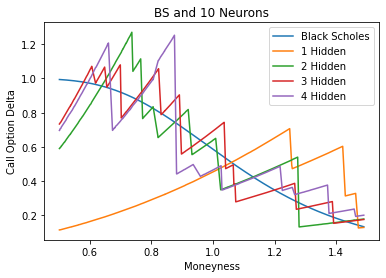

In [84]:
graph=pd.DataFrame(data=[Ms_g1,delta_g1,deltas_g1.iloc[:,0],deltas_g1.iloc[:,4],deltas_g1.iloc[:,8],deltas_g1.iloc[:,12]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Moneyness")
plt.ylabel("Call Option Delta")
plt.title("BS and 10 Neurons")
plt.legend();

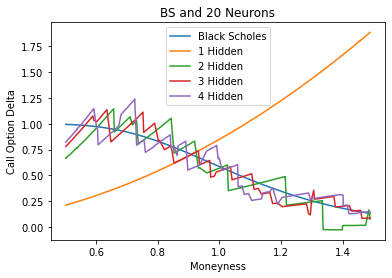

In [85]:
graph=pd.DataFrame(data=[Ms_g1,delta_g1,deltas_g1.iloc[:,1],deltas_g1.iloc[:,5],deltas_g1.iloc[:,9],deltas_g1.iloc[:,13]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Moneyness")
plt.ylabel("Call Option Delta")
plt.title("BS and 20 Neurons")
plt.legend();

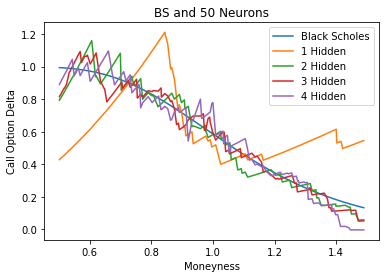

In [86]:
graph=pd.DataFrame(data=[Ms_g1,delta_g1,deltas_g1.iloc[:,2],deltas_g1.iloc[:,6],deltas_g1.iloc[:,10],deltas_g1.iloc[:,14]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Moneyness")
plt.ylabel("Call Option Delta")
plt.title("BS and 50 Neurons")
plt.legend();

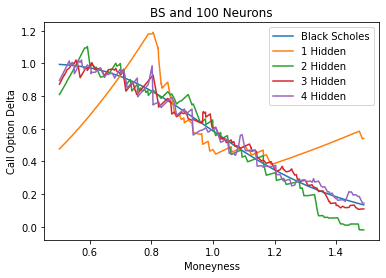

In [87]:
graph=pd.DataFrame(data=[Ms_g1,delta_g1,deltas_g1.iloc[:,3],deltas_g1.iloc[:,7],deltas_g1.iloc[:,11],deltas_g1.iloc[:,15]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Moneyness")
plt.ylabel("Call Option Delta")
plt.title("BS and 100 Neurons")
plt.legend();

Now we will build the Delta x Volatility Graphs.

We will again group the graphs by number of nodes in order to have a better visualization of the overall results.

The process to do this will be the following:

1. Fit the model with the respective architecture
2. Predict option prices before ($\hat{y}_1$) and after price change ($\hat{y}_2$) using the fitted model
3. Calculate delta using predicted prices and approximation equation
4. Store delta in dataframe for deltas with varying volatility
5. Loop through all the architectures using step 1 to 4
6. Plot 4 different graphs with deltas in Y axis and moneyness in X axis:
    - One with Black Scholes and all combinations of 10 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 20 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 50 neurons architecture (1,2,3 and 4 hidden layers)
    - One with Black Scholes and all combinations of 100 neurons architecture (1,2,3 and 4 hidden layers)

In [88]:
k=0
for i in [1, 2, 3, 4]:
    for x in [10, 20, 50, 100]:
        nn = train_model(hidden_layers=i, nodes = x, optimizer=optimizer).fit(X_train, y_train, epochs=100, batch_size = 200,
                                                                              verbose=0, validation_data=(X_test, y_test))
        yhat_1 = nn.model.predict(X_test_g2) # predicting option prices before change in stock price
        yhat_2 = nn.model.predict(X_test_g2_s) # predicting option prices after change in stock price
        delta_t = (yhat_2 - yhat_1) / 0.01 # calculating delta based on option price change
        deltas_g2[deltas_g2.columns[k]] = delta_t # storing deltas in a single dataframe
        k = k+1

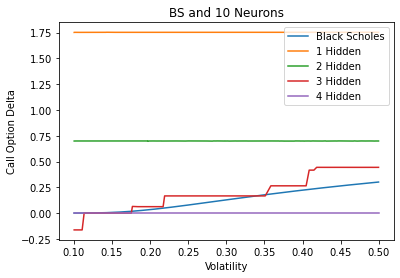

In [89]:
graph=pd.DataFrame(data=[Vs_g2,delta_g2,deltas_g2.iloc[:,0],deltas_g2.iloc[:,4],deltas_g2.iloc[:,8],deltas_g2.iloc[:,12]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Volatility")
plt.ylabel("Call Option Delta")
plt.title("BS and 10 Neurons")
plt.legend();

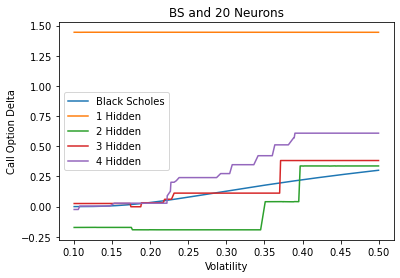

In [90]:
graph=pd.DataFrame(data=[Vs_g2,delta_g2,deltas_g2.iloc[:,1],deltas_g2.iloc[:,5],deltas_g2.iloc[:,9],deltas_g2.iloc[:,13]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Volatility")
plt.ylabel("Call Option Delta")
plt.title("BS and 20 Neurons")
plt.legend();

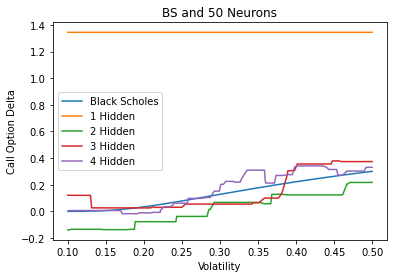

In [91]:
graph=pd.DataFrame(data=[Vs_g2,delta_g2,deltas_g2.iloc[:,2],deltas_g2.iloc[:,6],deltas_g2.iloc[:,10],deltas_g2.iloc[:,14]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Volatility")
plt.ylabel("Call Option Delta")
plt.title("BS and 50 Neurons")
plt.legend();

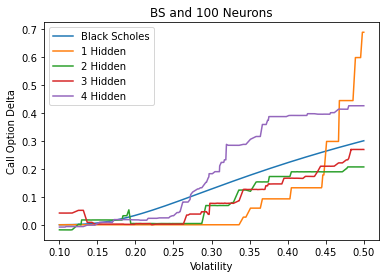

In [92]:
graph=pd.DataFrame(data=[Vs_g2,delta_g2,deltas_g2.iloc[:,3],deltas_g2.iloc[:,7],deltas_g2.iloc[:,11],deltas_g2.iloc[:,15]], index=['mon','del','del1','del2','del3','del4']).T
graph.sort_values(by=['mon'],inplace=True)
plt.plot(graph['mon'], graph['del'], label='Black Scholes')
plt.plot(graph['mon'], graph['del1'], label='1 Hidden')
plt.plot(graph['mon'], graph['del2'], label='2 Hidden')
plt.plot(graph['mon'], graph['del3'], label='3 Hidden')
plt.plot(graph['mon'], graph['del4'], label='4 Hidden')
plt.xlabel("Volatility")
plt.ylabel("Call Option Delta")
plt.title("BS and 100 Neurons")
plt.legend();

As it is clear form the graphs above, the delta aproximation is very far from good when using only one hidden layer. Nonetheless, starting with two hidden layers the approximations tend to be very close to the actual deltas. Adding more layers, lead to less approximation error. Also, it can be seen that increasing the number of neurons also improves a lot the estimation error.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# QUESTION 3

# Amazon Review Classification

In this question we will be studying a data set containing the information regarding purchases done through Amazon and their corresponding reviews. We will be using the Machine Learning technique called Natual Language Processing to classify the information given for which we will be assigning categories to the open ended text. 

We will base our analysis on the file 'Amazon_Unlocked_Mobile.csv' dataset published by Kaggle, which contains the following variables:
* Product Name
* Brand Name
* Price
* Rating
* Reviews
* Review Votes

We will try to classify the reviews in order to predict the rating obtained after each purchase.

## 1. Appetizer: Data Analysis

### Data download

In [93]:
# In this cell, we will import all the required packages to perform our analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
# Load train and test sets
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [95]:
# Overview of train set
train.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.9900,4,I love it!!! I absolutely love it!! 👌👍,0.0000
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.0000,5,I love the BLU phones! This is my second one t...,4.0000
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.9500,5,Great phone,1.0000
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.9900,4,Very happy with the performance. The apps work...,2.0000
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.9900,5,Easy to use great price,0.0000


In [96]:
# Overview of test set
test.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"Samsung 32GB Galaxy Note 10.1"" Android 4G LTE ...",NaN,499.9900,4,The speed of this tablet is unreal! It is by f...,24.0000
1,Kyocera Hydro C5170 PrePaid - Boost Mobile,NaN,27.4700,4,i had been shopping for a smart phone from boo...,1.0000
2,"Apple iPhone 6 Plus Unlocked Cellphone, 16GB, ...",Apple,519.0000,1,I would not recommend this phone.. It has a lo...,0.0000
3,HTC One M8 - Factory Unlocked 32GB - US Warran...,HTC,138.9900,1,NOT UNLOCKED!!!!! beware!!! Also as soon as I ...,NaN
4,T-Mobile Prepaid LG GS170 No-Contract Mobile P...,LG,299.9900,5,This phone is a gift for my 80's something fri...,0.0000


In [97]:
# Shapes of train, validation and test sets
print(train.shape, test.shape)

(5000, 6) (1000, 6)


As we can see, the train set is comprised by 5,000 observations while the test set is comprised by 1,000. This proportion means that we will be training our models on around 83.33% of the data sample. The standard is normally between 80% and 70%. We hope this proportion help us to have a more accurate classification model with out falling in an overfitting of the data.

#### Question 1
##### Tokenization

Our first step will be to prepare the data. When you are working with open ended text, there are several modifications to the original data set that have to be implemented. The objetive of this changes is to keep only the turthly relevant information and to not duplicate information. 

The first of this steps to prepare our data set will be to tokenize the data set. Tokenize refers to the action of breaking sentences into smaller pieces, in this case words. You can do it at a level sentence if you are breaking a document. We will break it into words so we can implement the following steps. 

In [98]:
# Tokenized the train set reviews
# We import the method word_tokenize that helps to extract all the words and elements within a sentence
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
reviews_tokenized_train = [word_tokenize(review) for review in train['Reviews']] # We loop through each of the reviews withih the column Reviews
for sentence in reviews_tokenized_train[:5]: print('%s \n'%sentence) # We print the elements to see how it looks

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\apala\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['I', 'love', 'it', '!', '!', '!', 'I', 'absolutely', 'love', 'it', '!', '!', '👌👍'] 

['I', 'love', 'the', 'BLU', 'phones', '!', 'This', 'is', 'my', 'second', 'one', 'this', 'year', 'and', 'not', 'because', 'there', 'is', 'anything', 'wrong', 'with', 'my', 'BLU', 'Studio', '6.0', 'HD', '.', 'I', 'have', 'just', 'opted', 'to', '``', 'upgrade', "''", 'to', 'a', 'phone', 'with', 'a', 'slightly', 'smaller', 'screen', 'and', 'better', 'battery', 'life', '.', 'For', 'the', 'price', 'of', 'these', 'phones', 'you', 'can', 'not', 'go', 'wrong.1', '.', 'Setup', 'is', 'a', 'breeze2', '.', 'customization', 'is', 'easy3', '.', 'colors', 'are', 'vibrant4', '.', 'phone', 'is', 'light', '(', 'even', 'with', 'a', 'rugged', 'case', ')', '5.', 'battery', 'life', 'is', 'better', 'than', 'any', 'phone', 'I', 'have', 'ever', 'had6', '.', 'Screen', 'is', 'responsive', 'to', 'touch', 'unlike', 'some', 'other', 'phones.I', 'have', 'had', 'no', 'issue', 'with', 'volume', 'or', 'music', 'playback', 'as', 'other'

As we can see, we have a list of list. Each of the sublist contains the elements and words within each review.

#### Question 2
##### Flatten the input data

As we can see above, we have a list of several list containing all the words per review. We would like to be able to identify the vocabulary used overall the data set. To permform this, it would be better to convert the data set into a 1 dimension vector. This is know as flattening. This also might come in handy when we  will be trying to use the data set as the input layer of a Nerual Network. 

In [99]:
# We will try to get the vocabulary within our data set
flatten_reviews_train = [item for sublist in reviews_tokenized_train for item in sublist]
flatten_reviews_train[0:35]
# This line of code flattens the inptut matrix, which was a list of lists. Each sublist
# was containing all the words within each review. After flattening the data, we get now
# one vector containing all the words overall the data set. We print only the first 35 
# observations

['I',
 'love',
 'it',
 '!',
 '!',
 '!',
 'I',
 'absolutely',
 'love',
 'it',
 '!',
 '!',
 '👌👍',
 'I',
 'love',
 'the',
 'BLU',
 'phones',
 '!',
 'This',
 'is',
 'my',
 'second',
 'one',
 'this',
 'year',
 'and',
 'not',
 'because',
 'there',
 'is',
 'anything',
 'wrong',
 'with',
 'my']

#### Question 3
#####  Vocabulary Count

Now, that we have our data set as a 1 dimension vector, we can proceed to count how many words are they in our data set. For this, we need to retrieve the unique elements within our words vector. This new vector with the unique elements will be referenced as the vocabulary set

In [100]:
# Count the train set vocabulary
# Set allows to get unique words that are in flatten_reviews
unique_words_train = list(set(flatten_reviews_train))
len(unique_words_train) 
# We use the len method to compute the number of unique elements,
# we checked the result with the following formula
# len(np.unique(flatten_reviews_train))

13099

#### Question 4
##### What are the five most common words? 

We will see now, what are the most common words in our vocabulary. This can be done easily with the FreqDist from nltk as shown below.

[('.', 10867), ('the', 8323), ('I', 6743), (',', 6551), ('and', 5429), ('it', 5217), ('phone', 5132), ('a', 4855), ('to', 4682), ('is', 3991), ('for', 2558), ('this', 2403), ('of', 2035), ('!', 1993), ('with', 1992), ('was', 1935), ('in', 1828), ('my', 1796), ('not', 1777), ('that', 1751)]


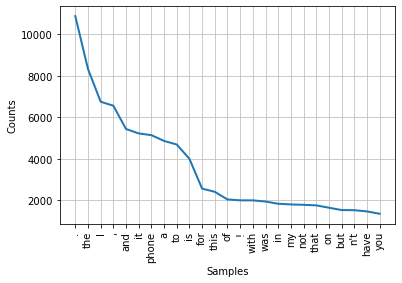

<AxesSubplot:title={'center':'word occurences distribution'}, xlabel='word occurrence', ylabel='probability density'>

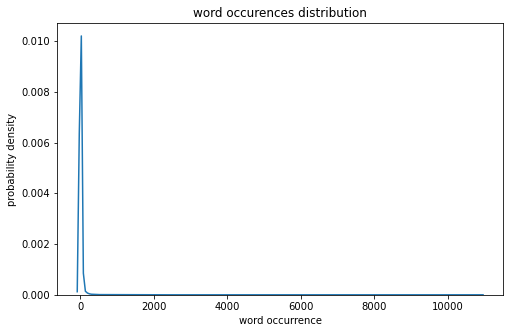

In [101]:
# Plot the distribution of words
# We import the method FreqDist
from nltk import FreqDist

# We need to pass to FreqDist the complete flattened word vector, not only the unique elements
freqDist = FreqDist(flatten_reviews_train)
# We print the 20 most common elements
print(freqDist.most_common(20))

# We create a normal plot that will allow us to the the tendency of the word counts
freqDist.plot(25, cumulative=False)
plt.show()
plt.figure(figsize=(8,5))
#Labeling features for readibility
plt.xlabel('word occurrence'); plt.ylabel('probability density'); plt.title('word occurences distribution')

# We create a vector containing the word count for each element to create a distribution plot
full_counts = [x[1] for x in freqDist.most_common()]
# Distribution plot
sns.kdeplot(full_counts)

As we can see in the first graph, the most common character is ".", which is not even a word. At this point, it is clear that some cleaning in our data set is still needed aa having punctuations as one of the most representative elements in the input set is very problematic. Some of the other most common words, like "and", "to", "with", etc., are known as Stop Words and are normally also eliminated as they have no real embedded meaning. This type of tokens will be erased further during this analysis before feeding our classification models. 

#### Question 5
##### Maximum lenght and only-one appereances

Another charactristics of our datasets that might be interesting to retrieve are how many characters does the longest word have and which words only appear once.

In [102]:
# To return the vocabulary word with the highest length and its corresponding length, we will use the method max by using the
# length of each word as the count criteria

max_len=max(flatten_reviews_train, key=len)
print(max_len, ':', len(max_len))

//forum.xda-developers.com/lg-g3/help/lost-usb-connection-mode-t2847857Going : 76


As we can see below, the longest token observed is some sort of website adress which got a space missing between it and the next word, so they are pasted together. The lenght of the total token in 76. This kind of information could be a problem further in our analysis

In [103]:
# This is an alternative way to find the longest token, this method uses a loop which might be less efficient but it allows to 
# search for other tokerns besides the one having the maximum lenght

maxlen = max(len(word) for word in flatten_reviews_train)
[word for word in flatten_reviews_train if len(word) == maxlen]

['//forum.xda-developers.com/lg-g3/help/lost-usb-connection-mode-t2847857Going']

In [104]:
# Now, to find the number of words in the vocabulary that appear only once in the reviews we will use the method Counter fro
# the package collections

import collections
from collections import Counter
wordcounts = Counter(flatten_reviews_train) #This functions helps to count the appereances per word within the vocabulary
a, b = zip(*wordcounts.items()) #The zip function helps to access the elemnts and its count
# Then we just create a DataFrame containing the words and their appereances
appereances = pd.DataFrame(data=[np.array(a),np.array(b)], index=['Word','Appereances']).T
appereances[appereances['Appereances']== 1] # Here, we consider only the words appearing once

,Word,Appereances
5,👌👍,1
49,wrong.1,1
51,breeze2,1
53,easy3,1
56,vibrant4,1
...,...,...
13094,👎,1
13095,booted,1
13096,beofre,1
13097,silenced,1


Here, we created a DataFrame, containing all the words and its count. We can see here that out of the 13,099 elemnts comprising our vocabulry, 7,273 appear only once. These words might not offer much information given that they are very specific.

As we have seen so far, our vocabulary for the train test, has a lot of outlayers, several punctuations, stopwords, lower and upper case differences, among other issues. In order to use this vocabulary to train our classification models we will need to deal with this problems.

#### Question 6
##### Building a vocabulary for the test set

Now, we will build a vocabulary list for the test set as we did for the test set. The steps we will follow are very similar to those followed so far.

In [105]:
# Tokenized the test reviews

reviews_tokenized_test = [word_tokenize(review) for review in test['Reviews']]
for sentence in reviews_tokenized_test[:5]: print('%s \n'%sentence)

# Here, we tokenize the reviews contained within the test set, in order to
# to be able to manipulate the test set at a word/element level.

['The', 'speed', 'of', 'this', 'tablet', 'is', 'unreal', '!', 'It', 'is', 'by', 'far', 'the', 'fastest', 'I', "'ve", 'had', 'my', 'hands', 'on', '.', 'The', 'UI', 'is', 'very', 'responsive', 'and', 'flows', 'between', 'apps', 'as', 'smooth', 'as', 'butter', '!', 'I', 'believe', 'the', 'Quadrant', 'score', 'was', 'around', '22,000', '!', 'However', ',', 'I', 'think', 'mine', 'may', 'be', 'faulty', '...', 'The', 'battery', 'life', 'is', 'subpar', 'and', 'even', 'my', '3', 'year', 'old', 'Acer', 'A700', 'has', 'more', 'than', 'twice', 'the', 'run', 'time', 'under', 'the', 'same', 'load', '.', 'I', "'m", 'seeing', 'around', '4', '-', '5', 'hours', 'of', 'actual', 'use', 'before', 'the', 'battery', 'drops', 'below', '25', '-', '30', '%', ';', 'below', 'that', ',', 'it', 'drains', 'very', 'rapidly', '.', 'That', 'is', 'with', '1', '-', '1.5', 'hours', 'of', 'games', 'and', 'the', 'remaining', 'time', 'watching', 'movies', 'or', 'web', 'surfing', '.', 'I', "'m", 'finding', 'myself', 'having',

In [106]:
# Test vocabulary creation

flatten_reviews_test = [item for sublist in reviews_tokenized_test for item in sublist]
unique_words_test = list(set(flatten_reviews_test))
len(unique_words_test) 

# As we did before, the flatten the data set in order to extract the implicit vocabulary.

5225

As it would be expected, the vocabulary of the test set (5,225 elements) is smaller than that of the train set (13,099)

#### Question 7
##### Train vs Test

Now, we will try to assess, how many of the words contained in the test set are not present in the train set. Hopefully, we won't get a high number.

In [107]:
# Here we will try to see which words that are present in the test set of reviews are also present in the train vocabulary

contained=[]
for words1 in unique_words_test:
    for words2 in unique_words_train:
        if words1==words2:
            contained.append(words1)

len(contained)

3786

Here, we obtained through a double loop, which are the words from the test vocabulary that are contained within the train vocabulary

In [108]:
# With this formula we can check that all the elements found above are actually
# contained in the train sample. As, the words were obtained from the test sample
# they will be contained in the test vocabulary, so no aditional check needed.

all(elem in unique_words_train for elem in contained)

True

In [109]:
# Lastly, we created a new list out of the train vocabulary droping
# those elements contaied in both, the train and the test, vocabularies

non_contained = [ele for ele in unique_words_test if ele not in contained]
len(non_contained)

1439

Out of the 5,225 words contained in the test set, there are 1,439 words that are not present in the test set, which accounts for 27.5% of the test sample. This number is not small, but we consider it is small enough to allow us to implement our classification method as almost 3/4 of the test sample will be used to train the model.

## 2. Main Course: Review Classification with Logistic Regression and BoW text encoding

Now, we will apply the Logistic Regression classification model by applying the Bag of Words method to our sample to process our data. All the work done before will serve as a basis to pepare our data.

### 2.1. Defining X (features vectors) and y (labels) sets

We will now start to implement our classification methods. To do so, We start by storing our features and labels in X_train, y_train, X_test and y_test. Then, we will try to predict the ratings that go from 1 to 5 based on the written reviews. We will transform our ratings so that the scale starts in 0. This means that, now, the ratings will range from 0 to 4. This will allow us to define the categorical cross-entropy as a loss function for the Neural Network that we will be training. The categorical cross-entropy is defined as follows:

$$C=-\frac{1}{m}\sum_{j=1}^{m}\sum_{k=1}^{K}y_{ik}\ln{p_{ik}}$$

Where K are the different possible ratings and m is the number of data points in the train sample.

In [110]:
# We define X_train and y_train from the train sample obtained above with the reviews for each purchase and we
# perform some adjustements. First, we assing a blank space whenever we dont count with a written review
X_train = train['Reviews'].fillna("")
# We transform the ratings by substracting 1 to each rating to have labels that starts at 0 
# to use sparse categorical cross-entropy as loss function for the NN training
y_train = train['Rating']-1
X_train.shape, y_train.shape

((5000,), (5000,))

In [111]:
# We perform the same step for the test set defined above
X_test = test['Reviews'].fillna("")
# Substract 1 to rating to have labels that starts at 0 
# to use sparse categorical cross-entropy as loss function for the NN training
y_test = test['Rating']-1
X_test.shape, y_test.shape

((1000,), (1000,))

#### Question 8

#### Clean Function

We will define a function that takes some text and return the cleaned version of it, considering the steps explained in the first part of this question, so that the processed data is ready to use it as an input for our classification method.

In [112]:
## We are going to define a function called "clean_text" which takes text as input and
## returns a clean text after several steps.
## We will explain all the different steps along the process. 


import nltk
nltk.download('stopwords') # This steps download a pre-built library of stop words as defined above, i.e. words with no real meaning
import string 
from nltk.tokenize import WhitespaceTokenizer # We import the method to tokenize the text
from nltk.stem import WordNetLemmatizer # We import the methdo to lemmatize the text. Lemmatize refers to a method that converts words to their root which helps reducing
                                        # in an important fashion the amount of words within a large text. This is useful as congugated words have the same meaning but in 
                                        # a simple tokenization they are accountes as if they were different words.
from nltk.corpus import stopwords # We import the method to remove the stop words

# In this step, we import a library containing the normal emojis found in this types of reviews. This will allow us to indentify them and remove them from the reviews as their
# meaning is normally redundant
try:
    import emoji
except:
    !pip install emoji
    import emoji


def clean_text(text):
    # The first step will be to remove from our data sample any emoji for the reason exposed above
    text = [c for w in text for c in w if c not in emoji.UNICODE_EMOJI]
    text = ''.join(text)
    
     # We convert all text to lower case so that we do not double count words that are written both with upper and lower case, as they are the same word
    text = text.lower()
    
     # We remove all the punctiation symbols as they do not have any real meaning associated with them
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
     # We remove any numbers found in the text as they information added regarding client satisfaction can be misleading
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
     # We, then, remove the stop words as they do not have any real meaning embedded
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
     # We remove the blank spaces, for examples the ones created when removing the emojis
    text = [t for t in text if len(t) > 0]
    
     # We lemmatize the words. The explanation of the process is above in this chunk of code
    text = [WordNetLemmatizer().lemmatize(t) for t in text]
    
     # We remove any word having less that two characters as they normally do not add much information
    text = [t for t in text if len(t) > 2]
    
    return " ".join(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apala\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
# We then used the defined Clean function to X_train and X_test which were previous preprocessing
X_train_cleaned = [clean_text(r) for r in X_train]
X_test_cleaned = [clean_text(r) for r in X_test]

#### Question 9

##### Logistic Regression

In this step, we will fit a logistic regression model. In order to be able to pass our data sample to the neural network in a more efficient manner we will transform our data into matrix using a Bag of Words (BoW). The Bag of Words is representation of the vocabulary from a text (the one containing the unique words) in which an index is assinged to each unique word. We, then, can use this vector to represent each review as a vector indicating how much times each word contained in the Bag of Words appears in it, resulting in a matrix of NxM, where N is the number of reviews and M is the number of elements in the Bag of Words.

In [114]:
# Using LogisticRegression from sklearn, fit a first model
from sklearn.linear_model import LogisticRegression # We import the logistic regression model
from sklearn.feature_extraction.text import CountVectorizer # We import the CountVectorizer method which allows us to transform our data set into a matrix representation based on the BoW
# Using classification_report, evaluate the model
from sklearn.metrics import classification_report # We import a model that will help us to proved clear performance statistics of our classification model
# Build, Fit and Evaluate a model using the previous preprocessing
from sklearn.metrics import accuracy_score # We import a model that will give us the accuracy of the predictions made

cv = CountVectorizer()

# Here, we create the Bag of Words associated to our data sample. This method will, implicitly, extract the vocabulary out of the data sample and create a BoW from it. We do this
# using the train vocabulary and then we use the resulting BoW to transform both the training and the test sample
cv.fit(X_train_cleaned)

# We transform our reviews into a vectorized form of the BoW. The resulting object is a NxM matrix
X_train_encoded = cv.transform(X_train_cleaned)
X_test_encoded = cv.transform(X_test_cleaned)

lr = LogisticRegression(max_iter=200)
lr.fit(X_train_encoded, y_train) # We fit the logistic regression to our data
y_pred = lr.predict(X_test_encoded) # We generate the predictions to compare with the test sample

# We finally, print the perfromance statistics
print('accuracy score: ',accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test))


# As explained above, the CountVectorizer allow us to represent the data sample in terms of a Bag of Words. Each review will be a vector with the same number of elements contained 
# in the BoW. The elements are the number of times that each word appears in the text. If the method CountVectorizer is set to Binary=True, then all the elements that are different
# to zero will be converted to 1. This might be useful in a binary classification model, meaning that you have only two classes or when how much the words appear in the text do not
# add much information to the classification task being done. In our case, we have more than two classes and the words frequency do matter, so binary should set as False. 

accuracy score:  0.657
              precision    recall  f1-score   support

           0       0.62      0.63      0.63       156
           1       0.12      0.21      0.15        28
           2       0.13      0.20      0.16        45
           3       0.23      0.44      0.30        84
           4       0.91      0.74      0.81       687

    accuracy                           0.66      1000
   macro avg       0.40      0.45      0.41      1000
weighted avg       0.75      0.66      0.69      1000



#### Question 10

##### Interpreting the results

As we can see from the overall accuracy result, which shows what percentage of the predicted value were correctly classified, is pretty low at 65.7%. But, then, while looking at the precision score, which reflects the proportion of the values well classified to each class to both the well and incorreclty classified data points at the corresponding class, we can see that the model is very good at capturing the data points belonging to the fifth class (5 stars) and first class, while it does not do very well in differentiating the data points belonging to the middle classes. 

This is consistent with what is observed in the recall and f1-score. The former reflects the proportion of correctly classified points to each class to both the correctly classified points and the points that should have been classified into the corresponding class but actually were not. The latter is a combination of both precision and recall and it is a more balanced performance metric than the accuracy, as it is not overly focused on correctly classified points as the accuracy metric. 

This point can be further stressed by comparing the macro average and the weighted average. The macro averages the metrics in an equally-weighted fashion, while the latter does so taking into account the proportion of data belonging to each class. The weighted average increases importantly as most of the reviews are focused on the last class. This reflects that our data set is quite unbalanced and, therefore, the model trained on such data gets very good at predicting the dominating class but it does not do so good in the other classes.

Below, we will explain how to compute each of the measures discussed here for the last class.

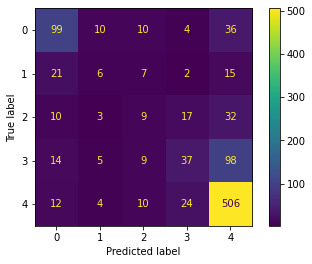

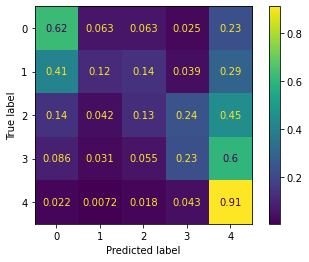

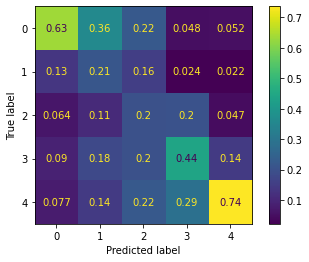

In [115]:
# Print/plot the confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr, X_test_encoded, y_test);
plot_confusion_matrix(lr, X_test_encoded, y_test, normalize='true');
plot_confusion_matrix(lr, X_test_encoded, y_test, normalize='pred')

### TO BE COMPLETED BY STUDENTS.

We created the confussion matrix, which allow us to see how the predictions were classified against how they should have been classified. We can use the data contained in them to compute the scores explanied above. For this, we need to look at the first matrix. The first step will be to compute the following metrics:

- $True Positives = 506$
- $False Positives = 12 + 4 + 10 + 24 = 50$
- $True Negatives = 1000 - 506 = 494$
- $False Negatives = 37 + 15 + 32 + 98 = 182$

Now, we can see how to compute each measure:

- $Precision = \frac{TP}{TP+FP} = \frac{506}{506+50} = 91.00\%$
- $Recall = \frac{TP}{TP+FN} = \frac{506}{506+182} = 73.54\%$
- $f-1 score = 2*\frac{Precision*Recall}{Precision+Recall} = 2*\frac{0.91*0.7354}{0.91+0.7354} = 81.35\%$

The second and the third matrix have the same information than the first matrix but scaled by the true value and the predicted value, accordingly. To understand it a little better, we can notice that the diagonal of the second matrix is equal to the precision score to each matrix and the diagonal of the second is equal to the recall score. 

#### Question 11

##### There was no question 11

#### Question 12

##### TfidfVectorizer

Now, we will repeat the same procedure as before but with a different method of vectorizing the data sample. The method is called TF-IDF, in which:

- TF stands for Term Frequency the number of times a specific element appears in each review
- IDF stands for Inverse Document Frequency the number of documents containing the element

$$IDF(t) = 1+ln\Big(\frac{1+N}{1+DF(t)}\Big)$$

$$TF-IDF = TF*IDF$$

So, the result of such vectorizing procedure will be a matrix just as in the Bag of Words method, but instead of having the counts of each word in each review as element, we will have the TF-IDF statistics. This will help us to give more importance to words that are hihgly present in some reviews even if it is not  that present overall the set of reviews, which is not possible using only the BoW.

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()

# Here, we create the Bag of Words associated to our data sample. This method will, implicitly, extract the vocabulary out of the data sample and create a BoW from it. We do this
# using the train vocabulary and then we use the resulting BoW to transform both the training and the test sample
tf_idf.fit(X_train_cleaned)

# We transform our reviews into a vectorized form of the BoW. The resulting object is a NxM matrix
X_train_encoded_2 = tf_idf.transform(X_train_cleaned)
X_test_encoded_2 = tf_idf.transform(X_test_cleaned)

lr = LogisticRegression(max_iter=200)
lr.fit(X_train_encoded_2, y_train) # We fit the logistic regression to our data
y_pred = lr.predict(X_test_encoded_2) # We generate the predictions to compare with the test sample

# We finally, print the perfromance statistics
print('accuracy score: ',accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test))

# As we explained before, the TF-IDF vectorizer goes one step further than Bag of Words by giving more importance to the most frequent elements within the vocabulary.
# Nevertheless, it is important to consider the meaning of some paramenters within the TfidVectorizer method.
# n_gram -> instead of searching the frequency of specific words, with this parameter we can look for the frequency of specific combinations of words. Basically, instead of separating 
#           by word, we will separate by groups of two words (in the case of n being 2). So, that one portion of text like "Product good performance" coming from "The product has
#           good performance" after cleaning, will be separeted in "product good" and "good performance" rather than "product", "good", "performance". In this example, we can see that
#           the the two bigrams offer a lot of meaning, while from the three words only one of them does. 
# min_df -> it sets a minimum frequency for each word to be considered part of the words vector
# max_df -> it sets a maximum frequency for each word to be considered part of the words vector
# binary -> it will transform all the non-zero frequency counts in the tf to 1 (not the TF-IDF number)

accuracy score:  0.677
              precision    recall  f1-score   support

           0       0.73      0.64      0.68       181
           1       0.04      1.00      0.08         2
           2       0.01      0.25      0.03         4
           3       0.14      0.45      0.21        51
           4       0.96      0.70      0.81       762

    accuracy                           0.68      1000
   macro avg       0.38      0.61      0.36      1000
weighted avg       0.87      0.68      0.75      1000



As we can see, the weighted average of all the scores improved compared to the previous excersice, in which we obtained 0.76, 0.66 and 0.69, even if the overall accuracy did not changed a lot (previous figure was 0.657). This improvement may be explained for the fact that we can give more importance to those terms that are highly present in some reviews. This information was lost in the example in which we used only BoW. 

Nonetheless, is important to notice that the prediction perfromance in the middel ratings actually went a little down except from the recall measure for the second rating, which went all the way up to 1.00 implying that no false negatives were classified in that class. Even if this last statement seems very good, it enough to see that this was a specific case given that this improvement for this class was not observed in the other performance measures. 

#### Question 13

#### Additional paramaters - Logistic Regression

In this question we will explain more in detail what does the parameters "penatly" and "C" within the logistic regression model imply. Before diving into the concepts, we need to remember that a logistic regression will try to stablish a linear relationship between some features and the label(s). To do so, it calculates the coefficients to each feature so that the loss fucntion, normally the Mean Squared Error, is minimized. Nonetheless, there could be some flaws within the data sample leading to some flaws in the fitting of the model. One of the problems may be having coefficients that are too big in comparison to others, gaining maybe too much relevand in the model. There are some methods that provide a solution for this kind of problems. They are called regularization methods and the most populares are Ridge and Lasso. Ridge method will penalize the loss function by adding the squared magnitude of the coefficients.

$$Ridge -> \sum_{n=1}^{N}(y_{i}-\hat{y}_{i})^2 + \lambda\sum_{n=1}^{N}\beta_{i}^2$$ 

On the other hand, the Lasso method will penalize by adding the absolute value of the coefficient to the loss function.

$$Lasso -> \sum_{n=1}^{N}(y_{i}-\hat{y}_{i})^2 + \lambda\sum_{n=1}^{N}|\beta_{i}|$$

This will implicitly force the optimization method to prefer coefficients thar are not too large given that they increase the loss function. An imporant characteristic of Lasso is that it will try to shrink the less important features coefficients to zero leading to a elimination of the less important features. This can be very useful when working with large feature space.

Then, the penatly parameter within the logistic regression tells which method of regularization to use. Another interesting paramenter is the C, which is the inverse of the regulatization strength. This can be taught as the inverse of lambda. When lambda is zero, there is no regularization at all. This will mean a high C. When C is small, meaning a high value of lambda, the regularization strenght is high and, therefore, the model will be giving a high weight to the penalty in the loss function optimization. 

## 3. Dessert: Review Classification with Neural Networks and Word Embedding

In this part of question, we will explore the Neural Networks approach and compare it to the results we obtained from the slighlty more simplistic linear regression approach. One of the main differences is that now we will using the keras library instead of the sklearn one. Before, we used the CountVectorizer and TdifdVectorizer to transform our reviews into a vectorized form so that we could extract features from them. The equivalent method in keras library is called Tokenizer, which has less options but it allows to use the availables GPUs to make the processing faster. 

In [117]:
from tensorflow.keras.preprocessing.text import Tokenizer # We import the Tokenizer method to vectorize the reviews

#### Question 14

##### Tokenizer method

In [118]:
# Create an instance of the Tokenizer class 
tokenizer = Tokenizer() 

# Here, we apply the vectorizaion method to our data sample. This method will, implicitly, also extract the vocabulary out of the data sample and create a vocabulary out of it.
# We will, then, use the resulting BoW to transform both the training and the test sample
tokenizer.fit_on_texts(X_train_cleaned) 

# We transform our reviews into a vectorized form of the BoW. The resulting object is list of sequences
sequences_train = tokenizer.texts_to_sequences(X_train_cleaned) 
sequences_test = tokenizer.texts_to_sequences(X_test_cleaned) 

So far, we stated that the basic idea behind Tokenizer and the other vectorization methods is the same. This is true but there is an important difference that we need to bear in mind. We can pass as a parameter to the method differents modes like binary, counts, frequency, TD-IDF, so to have a similar result as before. The problem is that both CountVectorizer and TdidfVectorizer should yield the same number of features as they create a matrix in which the number of columns is the number of words in the vocabulary. 

On the other hand, Tokenizer will create a list of sequences consisting on the representation of each word within the review. This means that we will only have the non zero terms, only a sequence of the representations of the words within each reviews. We can understand this as each review having different number of elements, while the previous methods will force every review to have the seme number of elements by adding zero to the non present words. 

#### Question 15

In [119]:
print(max([len(i) for i in sequences_train]))

512


In [120]:
print(max([len(i) for i in sequences_test]))

519


With the above two chunk of codes we can extract how many words does the longest review has in both the train set and the test set. The number of elements in each of them is 512 and 519, accordingly. We can be sure that there are only words in there as we have previously cleaned the data set before hand and because the Tokenizer method do account for punctuation terms my supressing them. 

#### Question 16

##### Pad_Sequence method

Now, we will introduce a method that allows to overcome the fact of each review having different number of elements. This method is call padding. It consists of adding zeros where there are no elements. This will lead to all reviews having the same number of elements. Nonetheless, we need to specify how long the resulting sequences will be. If we do not do this, the resuling vectors will be as long as maximum number of elements in the longest reviews. Therefore, it we would have vectors with a lenght of 512 in the train set and 519 in the test set. We would like them to have the same lenght, so we take the maximum of the two and pass that as parameter to the pad_sequence method. We will therefore get a matrix of size NxM as in the previous vectorizing methods.

In [121]:
from tensorflow.keras.preprocessing.sequence import pad_sequences # We download the padding method
maxlen = 520 
data_train = pad_sequences(sequences_train, maxlen) # We apply the padding method to our train set
data_test = pad_sequences(sequences_test,maxlen) # We apply the padding method to our test set
print(data_train.shape) 

(5000, 520)


#### Question 17

In this part of the question we will show how to acess the vocablary built by the Tokenizer method. Tokenizer creates a dictionary object comprising the vocabulary elements and the index assign to each element. In order to access it you use the word_index method as shown below.

In [122]:
list(tokenizer.word_index .items())[:10]

[('phone', 1),
 ('great', 2),
 ('good', 3),
 ('work', 4),
 ('one', 5),
 ('like', 6),
 ('battery', 7),
 ('screen', 8),
 ('use', 9),
 ('love', 10)]

In [123]:
word_index = tokenizer.word_index

# How many words are there actually?
nb_words =len(tokenizer.word_index)
print(nb_words)

7848


In the code above, we obtained the lenght of the dictionary created by Tokenizer. In this way we can now how many words are there in our vocabulary. Next, we will build a neural network to process our data. The architecthure of our neural network will consist of one embedding layer, one flatten layer, one hiden layer with 16 neuros and the output layer, which will have 5 neurons, one for each possible rating. The activation function of the output layer will be a soft max activation function, which is usually used in multicategorical classification method. 

We will train this neural network in order to be able to predcit ratings out of the reviews from the test set. It is important to expain before hand what the embedding layer will be doing. Embedding is a concept referring to a word represention as a vector. The idea is that represent each word a a vector of numbers so that our neural network can easily identify each word. A neural network cannot recognize a word as a word, but it can do so as a vector of numbers. There are multiple differents embedding methods. In this case, we will let the neural netwokr to choose the embedding representation that it founds to be optimal. 


#### Question 18

In [124]:
embedding_dim = 50

# In order to apply the embedding method, we need to choose before hand the length of the vectors that will be representing each words. In this case, we will be choosing
# 50 as the length of our vectors. 

#### Question 19

##### Artificial Neural Network construction

Let us construct the artificial neural network as specified above. As stated above, the embedding layer will transform each word into a vector of 50 elements as we will pass the embedding_dim paramenter specified above to the ANN. So, each review that was previously a vector containing 520 elements after the padding, will be transformed into a matrix of size 520x50, as each element/word, will be itselt a vector of size 50. 

In [125]:
# Build neural network model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
model = Sequential()

model.add(Embedding(nb_words+1, 
                    embedding_dim, 
                    input_length=maxlen)) 
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

# The main inputs into a embedding layer are:
# input_dim-> in which we specify the number of words contained in the vocabulary. In our case, we specified if as the nb_words retreived above plus one because the layer takes a range
#            of [0,nb_words+1), meaning that the last element is excluded.*********************************************
# output_dim-> the size of the vector we want to represent each word. In our case is 50
# embeddings_initializer-> We can choose a predefined initializer method to start the optimization method. This will apply a predefined method to choose the word representation
# embeddings_regularizer-> It is a regularizer method that we will apply to the output matrix. This will help us to avoid an overfitting on the overall model coming from the embedding
#                         weigths.
# embeddings_constraint-> This are restrictions set on the model that need to be met when choosing the embedding weights.
# mask_zero-> This helps to communicate to the model if the 0 are coming from a previous padding method.
# input_length-> This is the length of reviews as a vector. In our case is 520. When connecting a Flatten and Dense layers to the embedding layer, it is required to specify this
#                this paramenter as the output shape won't be able to be computed otherwise.

Model: "sequential_161"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 520, 50)           392450    
                                                                 
 flatten (Flatten)           (None, 26000)             0         
                                                                 
 dense_512 (Dense)           (None, 16)                416016    
                                                                 
 dense_513 (Dense)           (None, 5)                 85        
                                                                 
Total params: 808,551
Trainable params: 808,551
Non-trainable params: 0
_________________________________________________________________


#### Question 20

##### Parameters derivation

The number of paramenters in the first dense layer, the hidden layer is calculated to be 416,016. We will explain next how to get this number. First we need to stablish the following:

- As we explained before, the embedding layer will transform the 520 vector representation of each review to a 520x50 matrix
- The flatten layer will then transform this into a vector of size $520*50=26,000$
- Then, the dense layer will receive this 26,000 elements as inputs in each neuron. Each neuron will then have to find the optimal weight for each 26,000 elements, i.e. 26,000 weights, plus the corresponding bias term. Then, the number of paramenters at each neuron will be 26,001. Finally, as we have 16 neuros, the number of total paramenters at this point is $26,001*16=416,016$

Next, the number of parameters in the output layer is computed as 85. This can be easily found as follows:

- The previous hidden layer, has a ReLu actiavtion fuction wich will be taking as an input $z=\sum_{i=i}^{26,000}w_{ij}*x_{i}+b_{j}$ and will be outputing $x_{i}$ if $x>0$ or 0 if $x<0$
- So, the total output of the previous layer will be 16 elements. 
- So, each neuron will have to find the optimal weight of each of this elements, i.e. 16 weights, plus the bias term. This means that we will have 17 parameters at each neuron. As we have 5 neuros, then, the number of paramentes is $17*50=85$ 

##### 'SparseCategoricalCrossentropy' vs 'CategoricalCrossentropy'

As we explained above, the loss function that we will favour using is the Sparse Caterofical Cross Entropy loss function. We can use this loss function given that our date is not hot encoded. What we mean is that the label is not a matrix in which each rating is a vector in which each element represents a class. If this were the case, each review would be containing zeros except from the element corresponding to class to which the rating corresponds. This is know as hot econded data. In our case, each ratings has a number ranging from 0 to 4, so instead of being a vector, each rating is an integer. This makes the optimization problem more fast to solve. Both, categorical cross entropy and sparse categorical cross entropy have the same loss function:

$$J(w)=−\frac{1}{N}\displaystyle\sum_{i=1}^{N}\sum_{j=1}^{K}y_{ij} log(\hat{y_{ij}})$$ 

Where: 

* $w$ refers to the model parameters, e.g. weights of the neural network
* $y_i$ is the true label
* $\hat{y_i}$ is the predicted label
* $K$ is the number or classes or ratings

The difference is that $y_{i}$ is a vector in the case of the Categorical Cross Entropy case, while in the Sparse Categorical Corss Entroppy it is an integer. After this brief explanation, we will proceed to train the neural network built above.

In [126]:
model.compile(optimizer='adam', # We specify which Gradient Descent to use while performing the optimization of the model
              loss='SparseCategoricalCrossentropy', # We specify what loss function to use
              metrics=['acc'])

In [127]:
# We fit the model to our data sets built in Question 16

history = model.fit(data_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(data_test, y_test))

Epoch 1/10
157/157 [==============================] - 3s 14ms/step - loss: 1.2517 - acc: 0.5428 - val_loss: 1.1162 - val_acc: 0.6010
Epoch 2/10
157/157 [==============================] - 2s 12ms/step - loss: 1.0300 - acc: 0.6454 - val_loss: 1.0077 - val_acc: 0.6390
Epoch 3/10
157/157 [==============================] - 2s 12ms/step - loss: 0.8649 - acc: 0.6852 - val_loss: 0.9749 - val_acc: 0.6500
Epoch 4/10
157/157 [==============================] - 2s 12ms/step - loss: 0.7447 - acc: 0.7152 - val_loss: 0.9813 - val_acc: 0.6600
Epoch 5/10
157/157 [==============================] - 2s 12ms/step - loss: 0.6021 - acc: 0.7958 - val_loss: 1.0219 - val_acc: 0.6480
Epoch 6/10
157/157 [==============================] - 2s 13ms/step - loss: 0.4709 - acc: 0.8536 - val_loss: 1.0797 - val_acc: 0.6360
Epoch 7/10
157/157 [==============================] - 2s 13ms/step - loss: 0.3750 - acc: 0.8894 - val_loss: 1.1387 - val_acc: 0.6480
Epoch 8/10
157/157 [==============================] - 2s 13ms/step - 

#### Question 21

##### argmax function

In [128]:
y_pred = model.predict(data_test)
y_pred = np.argmax(y_pred, axis=1)

In this step, we use the trained model to predict the the rating to each reviews within the test set. We need to remember that the activation fuction of the output layer was a softmax function defined as follows:

$$p(k|x) = \frac{exp^{z_{k}^{(L)}(x)}}{\sum_{j=1}^{K}exp^{z_{k}^{(L)}(x)}}$$

Where k represents the class or the ratings. This means the the softmax option will compute a probability for the element received to belong to each class. In our case, there were 5 classes thats why the output of our output layer in the neural network defined above was set to 5. 

This also means that each predicted label, $\hat{y}_{i}$, will be a vector of 5 probabilities. What we care is only the highest probability out of the 5 obtained, which suggests that the review will most likely lead to the corresponding class or rating. With the function argmax in the above chunk of code we get the index of the highest probability within each probability vector. This will transform our predicted probability matrix to a vector containing the predicted label for each review. 

In [129]:
print('accuracy score: ',accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test))

accuracy score:  0.632
              precision    recall  f1-score   support

           0       0.56      0.66      0.61       135
           1       0.08      0.36      0.13        11
           2       0.18      0.19      0.18        70
           3       0.19      0.31      0.24        99
           4       0.89      0.72      0.80       685

    accuracy                           0.63      1000
   macro avg       0.38      0.45      0.39      1000
weighted avg       0.72      0.63      0.67      1000



<AxesSubplot:>

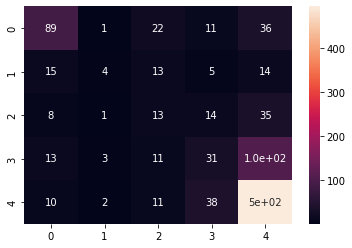

In [130]:
# Print/plot the confusion matrix
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)

<AxesSubplot:>

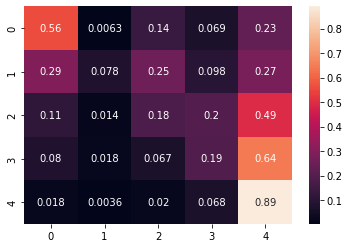

In [131]:
# Print/plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'),annot=True)

<AxesSubplot:>

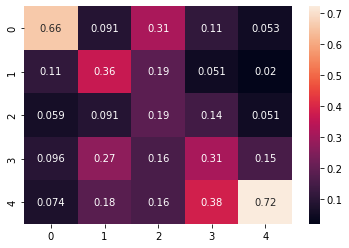

In [132]:
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='pred'),annot=True)

#### Question 22: Interpret the results for this model (accuracy score, confusion matrix).

Finally, we computed the performance measures of the new model. This can be compared with the results obtained on the models above in which we had:

- Weighted Average from Logistic Regression BoW -> Precision:0.75 , Recall: 0.66, f-1:0.69
- Weighted Average from Logistic Regression TF-IDF -> Precision: 0.87, Recall: 0.68, f-1:0.75
- Weighted Average from ANN -> Precision: 0.72, Recall: 0.63, f-1:0.67

We can see that, even though, the ANN perfromance is the lower of all, it is super close the one obtained from the logistic regression based on the Bag of Words vectorization method. This makes sense as the tokenization method from the keras library, after padding, should yield an equivalent vector represantion to the one we obtained with the CountVectorizer method. What is interesting is that the embedding layer seems to do a good job, or at least similar, compared to the Bag of Words method. It also makes sense that the ANN has a worst performance compared to the TD-IDF word vectorization method given that, as we stated above, it captures more information by assinging more weight to those words that are specially present in some reviews despite the fact that they might not be very present in the overall set of reviews. An interesting additional step would be to ask the Tokenizer method to use a TD-IDF criteria to form the review's vector representation. Results should improve and, maybe, the ANN will be better at capturing this additional information than the more simpler logistic regression approach. Finally, if we observe the color distribution of the confussion matrices obtained now and before we can notice that is basically the same and that the worst performance is still concentrated in the middle raitings area. 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# QUESTION 4

In this question, we wil be working the Recursive Neural Network.This type of Neural Network allows to preserve the importance of how data is ordered. This is specially useful when working with time series for example. One special kind of RNN are the Long Short Term Model and the GRU model. This two models allow the RNN to have both short and long-term memory which is very useful when trying to predict more that one period ahead. We will be comparing this two models troughout the question.

## 1. Seasonal Time Series Prediction using an RNN

We made two main corrections to the code of the deafult RNN from the class:
1. Added a dense layer with 200 neurons after the LTSM one. The model was very good at predicting the seasonality, but consistently underestimated the time series (did not learn on the data within the year).
2. Increase the patience coefficient from 2 to 3. Even though the model trained at class showed very good prediction accuracy, it is still unstable and the code do not deliver a model as accurate every time. Thus, we need to modify the code to add more stability to the training, in case we will need to train the same model on different datasets/periods.

To save time, go straight to the 'Comparing the Models' section. There is no changes before that, apart from 'Building the Model' section. All the changes are described above.

Finally, we had a suspicion there may be a Look-Ahead bias 'illegaly' improving the prediction accuracy, but the labels are clearly correct after using Timeseries Generator. It seems that the prediction are so accurate just because of extremely similar data in the preceding 5 years.

### Preparing the Data

To perform our model comparsion, we will try to predict on the Retail Sales: Clothing and Clothing Accessory Stores data series from FRED.
https://fred.stlouisfed.org/series/MRTSSM448USN

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [134]:
# to deal with the warnings
pd.options.mode.chained_assignment = None

In [135]:
import pandas_datareader.data as web
df = web.DataReader("MRTSSM448USN", 'fred', start="19920101") # We downloead the correct dataset

In [136]:
df.head(5)

,MRTSSM448USN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


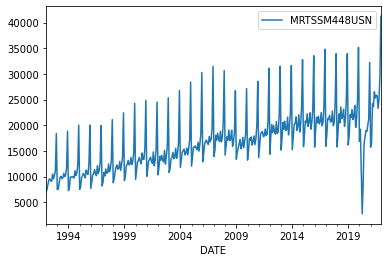

In [137]:
df.plot();

Here is a plot of the dataset, allowing us to see that there is creal seasonality in the dataset. The drop at the end is due to the pandemic. Let's drop it.

In [138]:
df = df[0:334]

The resulting data series we want to predict looks like this

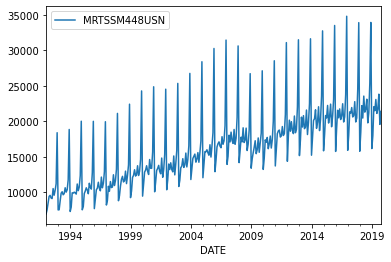

In [139]:
df.plot();

We have monthly data. As explained in question 1, when using time seires, we need to perform a test train split that preserves the order whithin the data. We will consider the last 18 months for the test size. 

In [140]:
n_train = df.shape[0] - 18

In [141]:
df_train = df[0:n_train]
df_test  = df[n_train:]

In [142]:
len(df_train), len(df_test)

(316, 18)

In [143]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_train)

MinMaxScaler()

In [144]:
df_train_scaled = scaler.transform(df_train)
df_test_scaled = scaler.transform(df_test)

### Batching using the Time Series Generator

We will be using the time series generator classs which makes time series batching more efficient.

In [145]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [146]:
batch_length = 12 # Must be less than the size of the test set
batch_size = 1 # Number of batches in each training iteration

generator = TimeseriesGenerator(df_train_scaled, 
                                df_train_scaled, 
                                length=batch_length, 
                                batch_size=batch_size)

Let's examine the first batch

In [147]:
X, y = generator[0]

In [148]:
X

array([[[0.        ],
        [0.02101413],
        [0.05511726],
        [0.08832389],
        [0.09395396],
        [0.08047049],
        [0.07763752],
        [0.12820053],
        [0.09449186],
        [0.11891272],
        [0.15237037],
        [0.41085132]]])

In [149]:
y

array([[0.0202252]])

We can see the same first batch numbers and the next value below in the raw training data.

In [150]:
df_train_scaled[0:13]

array([[0.        ],
       [0.02101413],
       [0.05511726],
       [0.08832389],
       [0.09395396],
       [0.08047049],
       [0.07763752],
       [0.12820053],
       [0.09449186],
       [0.11891272],
       [0.15237037],
       [0.41085132],
       [0.0202252 ]])

### Building a Prediction Model using RNNs

Now, we will build our first Recursive Neural Network.

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, TimeDistributed
from tensorflow import keras

In [152]:
n_features = 1 # it's a time series

In [153]:
validation_generator = TimeseriesGenerator(df_test_scaled, df_test_scaled, 
                                           length=batch_length, batch_size = batch_size)

#### Default Model

The RNN will have one LSTM layer with 200 neurons

In [154]:
model_default = Sequential()
model_default.add(LSTM(200, activation="relu", input_shape=(batch_length, n_features)))
model_default.add(Dense(1))
model_default.compile(optimizer='adam', loss='mse')

Next, we will fit the model and geenerate another time series using the validation data set. This will give our prediction. Given that the output layer has 1 node, we will only be predicting one period ahead.

In [155]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", patience = 2)

model_default.fit(generator, epochs=20, 
          validation_data = validation_generator, 
          callbacks = [early_stop])

Epoch 1/20
304/304 [==============================] - 6s 11ms/step - loss: 0.0247 - val_loss: 0.0033
Epoch 2/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0121 - val_loss: 0.0047
Epoch 3/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0040 - val_loss: 0.0093


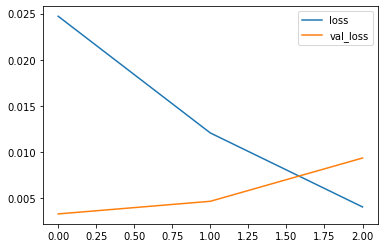

In [156]:
losses = pd.DataFrame(model_default.history.history)
losses.plot();

We can see that the training loss decreases as expected and that the errors are very low in magnitude overall. This suggests that the model is very good at capturing the data seasonality.

#### Modified Model

Now, we will add the changes described at the beggining of this question.

In [157]:
model_new = Sequential()
model_new.add(LSTM(200, activation="relu", input_shape=(batch_length, n_features)))
model_new.add(Dense(200))
model_new.add(Dense(1))
model_new.compile(optimizer='adam', loss='mse')

In [158]:
model_new.summary()

Model: "sequential_163"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_515 (Dense)           (None, 200)               40200     
                                                                 
 dense_516 (Dense)           (None, 1)                 201       
                                                                 
Total params: 202,001
Trainable params: 202,001
Non-trainable params: 0
_________________________________________________________________


This time we will also set an early stopping mechanism, so it does not take forever. Nevertheless, we observed that this was a vulnerable part of the default model, as some times the model training stopped too early, lowering the prediction accuracy. We will, then, set the patience coefficient to 3 to avoid that.

In [159]:
#from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", patience = 3)

Generate another time series using the validation data.

In [160]:
model_new.fit(generator, epochs=20, 
          validation_data = validation_generator, 
          callbacks = [early_stop])

Epoch 1/20
304/304 [==============================] - 5s 10ms/step - loss: 0.0258 - val_loss: 0.0027
Epoch 2/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0178 - val_loss: 0.0033
Epoch 3/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0078 - val_loss: 0.0042
Epoch 4/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0029 - val_loss: 0.0044


In [161]:
losses = pd.DataFrame(model_new.history.history)

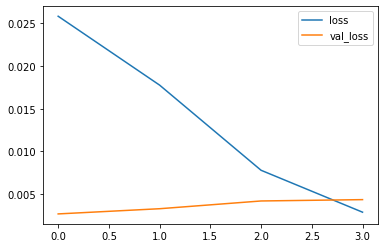

In [162]:
losses.plot();

We can observe already a slight improvement regarding the default model. Although, as every training yields different results, one should be careful when comparing both plots.

### Models Comparison (Default vs New)

Let's see how well the prediction looks against the test set.

In [163]:
test_predictions = []
first_eval_batch = df_train_scaled[-batch_length:]
current_batch = first_eval_batch.reshape((1, batch_length, n_features))

Text(0.5, 1.0, 'Predictions using the Defualt model')

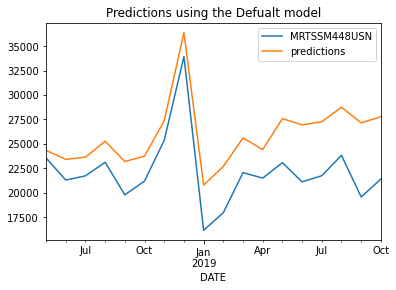

In [164]:
# We construct a loop to perform a prediction for every point within the test set

for i in range(len(df_test)):
    
    # predict one time step ahead
    current_pred = model_default.predict(current_batch)[0]
    
    # store the prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
df_test['predictions'] = true_predictions;
df_test.plot();
plt.title("Predictions using the Defualt model")

We can see on the plot above that, as we mentioned, the default network consistently makes mistakes in the same direction. It is almost like the LSTM layer concentrates on the seasonality so much, the monthly change is of little importance to it.

Text(0.5, 1.0, 'Predictions using the modified model')

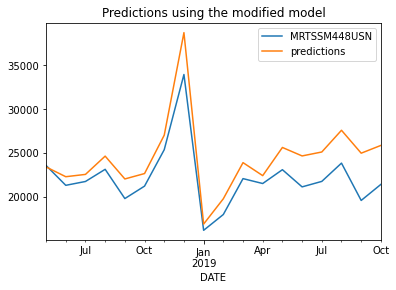

In [165]:
test_predictions = []
first_eval_batch = df_train_scaled[-batch_length:]
current_batch = first_eval_batch.reshape((1, batch_length, n_features))

for i in range(len(df_test)):
    
    # predict one time step ahead
    current_pred = model_new.predict(current_batch)[0]
    
    # store the prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
df_test.predictions = true_predictions;
df_test.plot();
plt.title("Predictions using the modified model")

Now the predictions are closer to the reality.

## 2. Sequence-to-Sequence Model: LSTM vs GRU

Next, we will modify our models in two ways. We will first change our models so that we can predict several periods ahead, rather that only one. This kind of models are called sequence-to-sequence model. We will first test the current LSTM architecture and then, we will test the alternative architecture GRU.

First, we need to change the structure of the dataset, so that the target output is not just 1 value any more, but n values, where n varies from 1 to 5. Thus, 5 dataset structures are created below.

In [166]:
target_2=np.concatenate((np.roll(df_train_scaled, -1, axis=0),
                                      np.roll(df_train_scaled, -2, axis=0),
                                      ),axis=1)

target_3=np.concatenate((np.roll(df_train_scaled, -1, axis=0),
                                      np.roll(df_train_scaled, -2, axis=0),
                                      np.roll(df_train_scaled, -3, axis=0)
                                      ),axis=1)

target_4=np.concatenate((np.roll(df_train_scaled, -1, axis=0),
                                      np.roll(df_train_scaled, -2, axis=0),
                                      np.roll(df_train_scaled, -3, axis=0),
                                      np.roll(df_train_scaled, -4, axis=0)
                                      ),axis=1)

target_5=np.concatenate((np.roll(df_train_scaled, -1, axis=0),
                                      np.roll(df_train_scaled, -2, axis=0),
                                      np.roll(df_train_scaled, -3, axis=0),
                                      np.roll(df_train_scaled, -4, axis=0),
                                      np.roll(df_train_scaled, -5, axis=0)
                                      ),axis=1)

targets  = [df_train_scaled, target_2, target_3, target_4, target_5]

Same for the test set.

In [167]:
target_2=np.concatenate((np.roll(df_test_scaled, -1, axis=0),
                                      np.roll(df_test_scaled, -2, axis=0),
                                      ),axis=1)

target_3=np.concatenate((np.roll(df_test_scaled, -1, axis=0),
                                      np.roll(df_test_scaled, -2, axis=0),
                                      np.roll(df_test_scaled, -3, axis=0)
                                      ),axis=1)

target_4=np.concatenate((np.roll(df_test_scaled, -1, axis=0),
                                      np.roll(df_test_scaled, -2, axis=0),
                                      np.roll(df_test_scaled, -3, axis=0),
                                      np.roll(df_test_scaled, -4, axis=0)
                                      ),axis=1)

target_5=np.concatenate((np.roll(df_test_scaled, -1, axis=0),
                                      np.roll(df_test_scaled, -2, axis=0),
                                      np.roll(df_test_scaled, -3, axis=0),
                                      np.roll(df_test_scaled, -4, axis=0),
                                      np.roll(df_test_scaled, -5, axis=0)
                                      ),axis=1)

targets_test  = [df_test_scaled, target_2, target_3, target_4, target_5]

Second, the model architecture should also account for the number of desired outputs, the number of periods predicted ahead, – thus we need flexible functions for model creation. We construct such function next.

In [168]:
def build_ltsm(n):
    model = Sequential()
    model.add(LSTM(200, activation="relu", input_shape=(batch_length, n_features), return_sequences=True)) # In order to predict several periods ahead we need to ask the RNN to output a sequence
    model.add(TimeDistributed(Dense(n))) # The time distributed layer allow us to apply a dense layer to each of our inputs
                                         # Each dense layer will give n output, the number of predicted periods, which then will be
                                         # averaged
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(n):
    model = Sequential()
    model.add(GRU(200, activation="relu", input_shape=(batch_length, n_features), return_sequences=True))
    model.add(TimeDistributed(Dense(n))) # The explanation for this layer is the same as in the previous function
    model.compile(optimizer='adam', loss='mse')
    return model

Next, we create a loop function that will be looping over the number of periods to predcit and will be training the two models definded above. We will create a graph showing how the training an validation errors behave so we can perform a better comparison between them.

Epoch 1/20
304/304 [==============================] - 5s 10ms/step - loss: 0.0295 - val_loss: 0.0146
Epoch 2/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0126 - val_loss: 0.0081
Epoch 3/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 4/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 5/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 6/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0017 - val_loss: 8.9792e-04
Epoch 7/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 8/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0014 - val_loss: 8.3255e-04
Epoch 9/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 10/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0012 - val_lo

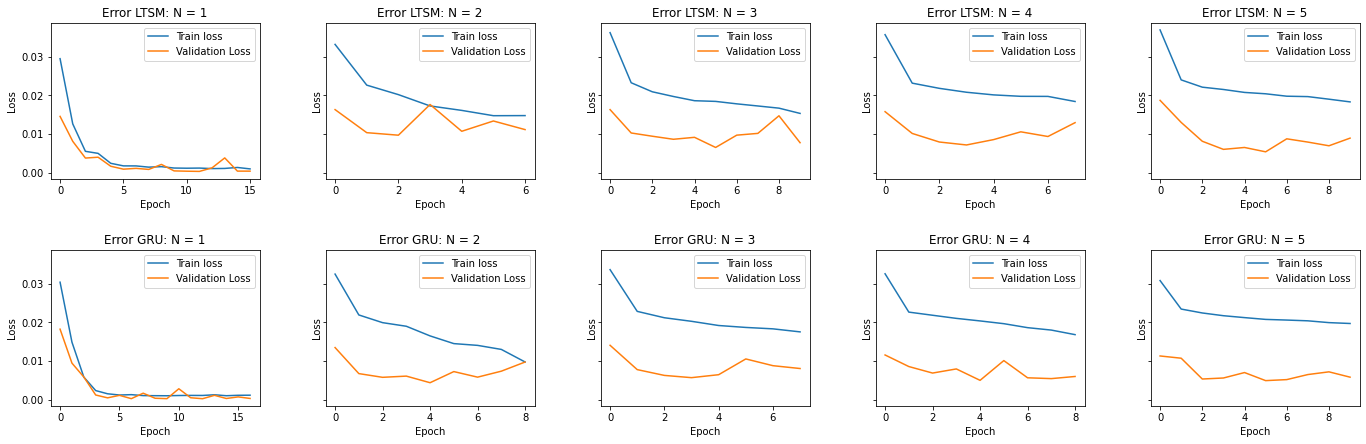

In [169]:
# We create the grid where the graphs will be displayed
fig, axs = plt.subplots(nrows = 2, ncols=5, sharey=True, figsize=(20, 7))
fig.tight_layout(pad=5.0)
line_labels = ["Train loss", "Validation Loss"]

early_stop = EarlyStopping(monitor="val_loss", patience = 4)

for i in [1, 2, 3, 4, 5]: # loop over Ns and fix batch length at 12

    generator = TimeseriesGenerator(df_train_scaled, targets[i-1], length=12, batch_size = 1)
    validation_generator = TimeseriesGenerator(df_test_scaled, targets_test[i-1], length=12, batch_size = 1)

    # train and plot LSTM

    # use the last NN architecture and Early Stopping parameters
    model_ltsm = build_ltsm(i)
    model_ltsm.fit(generator, epochs=20, 
          validation_data = validation_generator, 
          callbacks = [early_stop])

    # plot the error improvement
    axs[0][i-1].plot(model_ltsm.history.history["loss"])
    axs[0][i-1].plot(model_ltsm.history.history["val_loss"]);
    axs[0][i-1].set_title('Error LTSM: N = '+str(i));
    axs[0][i-1].set(xlabel="Epoch", ylabel="Loss");
    axs[0][i-1].legend(labels=line_labels, loc="upper right");

    # train and plot GRU
    model_gru = build_gru(i)
    model_gru.fit(generator, epochs=20, 
          validation_data = validation_generator, 
          callbacks = [early_stop])

    # plot the error improvement
    axs[1][i-1].plot(model_gru.history.history["loss"])
    axs[1][i-1].plot(model_gru.history.history["val_loss"]);
    axs[1][i-1].set_title('Error GRU: N = '+str(i));
    axs[1][i-1].set(xlabel="Epoch", ylabel="Loss");
    axs[1][i-1].legend(labels=line_labels, loc="upper right");


As we can see above, MSEs of the two methods are similar, but GRU seems to outperform LSTM at all the time horizons (Y axes on plots are shared). Moreover, MSE of GRU is more stable, which means lower chances of overfitting.

Finally, as we expected – with higher prediction horizon the error increases: for N=1 the MSE is almost zero, while at N=5 it bumps up to 0.01 in the GRU model.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# QUESTION 5

In this question, we will be analyzing the performance of the Autoncoders architectures. This architectures are based on a symmetric structure. The first part compresses the data obtained and the second part tries to reconstrut the original data set out of the encoded information. We will be training our model on the MNIST FASHION data set while varying the number neurons in the bottle neck layer (the layer at which the data set has its lowest representation in terms of dimension).

In [170]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

In [171]:
from tensorflow.keras.datasets import fashion_mnist

### 5.1 We start by loading the dataset and preparing the data

In [172]:
mnist = tf.keras.datasets.mnist

Train / Test split

In [173]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Resampling data

In [174]:
x_train_s, x_test_s = x_train.reshape(60000, 784) / 255, x_test.reshape(10000, 784) / 255

In [175]:
x_train_s.shape

(60000, 784)

In [176]:
x_train_s[0].shape

(784,)

In [177]:
x_test.shape

(10000, 28, 28)

### 5.2 We create an Autoencoder with a structure [400, 200, 100, 50, N, 50, 100, 200, 400]

N will be looped through [50, 25, 10, 5]

We will do this by creating a looping function that outputs the Autoencoder model.

For this reconstruction model, we wil use:

- Sigmoid activation in the output layer (last layer in decoder)
- Loss function: Mean Squared Error
- Metric: Loss of the validation set

We chose to use the combination MSE + val_loss as it yielded better results in comparison to the combination Binary Crossentropy + Accuracy.

In [178]:
# Defining the autoencoder architecture
def build_autoencoder(N):

    encoder = Sequential()
    encoder.add(Dense(400,  activation='relu', input_shape=(784,)))
    encoder.add(Dense(200,  activation='relu'))
    encoder.add(Dense(100,  activation='relu'))
    encoder.add(Dense(50,   activation='relu'))
    encoder.add(Dense(N,   activation='relu')) # Bottleneck

    decoder = Sequential()
    decoder.add(Dense(50,  input_shape=[N], activation='relu'))
    decoder.add(Dense(100,  activation='relu'))
    decoder.add(Dense(200,  activation='relu'))
    decoder.add(Dense(400,  activation='relu'))
    decoder.add(Dense(784,  activation='sigmoid'))
    
    autoencoder = Sequential([encoder, decoder])
    
    autoencoder.compile(loss='MSE', optimizer = Adam())
    
    return autoencoder

In [179]:
# Creating a results DataFrame to store the validation loss on the test set 
results = pd.DataFrame(index=['MSE'])

Now we will loop through the desired values of N and store the MSE of each in our DataFrame

In [180]:
# We use x_train_s as both input and output data, since the autoencoder is recreating the initial images
for n in [50, 25, 10, 5]:
    trained_model = build_autoencoder(n).fit(x_train_s, x_train_s, batch_size=1024, 
                                epochs=10, verbose=1, 
                                validation_data=(x_test_s, x_test_s))
    results[n] = trained_model.history['val_loss'][-1]

Epoch 1/10
59/59 [==============================] - 4s 63ms/step - loss: 0.0922 - val_loss: 0.0671
Epoch 2/10
59/59 [==============================] - 3s 51ms/step - loss: 0.0595 - val_loss: 0.0509
Epoch 3/10
59/59 [==============================] - 3s 47ms/step - loss: 0.0452 - val_loss: 0.0392
Epoch 4/10
59/59 [==============================] - 3s 47ms/step - loss: 0.0364 - val_loss: 0.0334
Epoch 5/10
59/59 [==============================] - 3s 48ms/step - loss: 0.0316 - val_loss: 0.0295
Epoch 6/10
59/59 [==============================] - 3s 53ms/step - loss: 0.0283 - val_loss: 0.0264
Epoch 7/10
59/59 [==============================] - 3s 59ms/step - loss: 0.0261 - val_loss: 0.0252
Epoch 8/10
59/59 [==============================] - 3s 59ms/step - loss: 0.0246 - val_loss: 0.0234
Epoch 9/10
59/59 [==============================] - 4s 62ms/step - loss: 0.0231 - val_loss: 0.0223
Epoch 10/10
59/59 [==============================] - 4s 64ms/step - loss: 0.0219 - val_loss: 0.0211
Epoch 1/1

In [181]:
results

,50,25,10,5
MSE,0.0211,0.0222,0.0271,0.0383


### Results interpretation

Observing the results in the DataFrame, as we decrease the number of nodes in the Bottleneck layer the loss on the validation data goes up. This makes sense since the more we reduce the dimension of the initial images, the more we loose information and, therefore, performance. Although, it is important to state that a strict look at the MSE can be misleading at some point. One of the advantages of the autoenconders is that they can filter our some of the noise embedded in the data set. So, a very low MSE result not always is a good signal.

### 5.3 - Generating a non-image

Now, we will pass a couple of images that are completely different from the ones in the MNIST dataset. We will try to reconstruct these images using our build_autoencoder function.

In [182]:
# We build and fit our model using N = 50, for maximum performance
trained_model = build_autoencoder(50).fit(x_train_s, x_train_s, batch_size=1024, 
                                epochs=10, verbose=1, 
                                validation_data=(x_test_s, x_test_s))

Epoch 1/10
59/59 [==============================] - 4s 57ms/step - loss: 0.0987 - val_loss: 0.0713
Epoch 2/10
59/59 [==============================] - 3s 57ms/step - loss: 0.0660 - val_loss: 0.0600
Epoch 3/10
59/59 [==============================] - 4s 70ms/step - loss: 0.0553 - val_loss: 0.0503
Epoch 4/10
59/59 [==============================] - 4s 67ms/step - loss: 0.0435 - val_loss: 0.0382
Epoch 5/10
59/59 [==============================] - 4s 64ms/step - loss: 0.0351 - val_loss: 0.0322
Epoch 6/10
59/59 [==============================] - 3s 58ms/step - loss: 0.0307 - val_loss: 0.0287
Epoch 7/10
59/59 [==============================] - 4s 62ms/step - loss: 0.0276 - val_loss: 0.0258
Epoch 8/10
59/59 [==============================] - 4s 67ms/step - loss: 0.0254 - val_loss: 0.0247
Epoch 9/10
59/59 [==============================] - 4s 65ms/step - loss: 0.0241 - val_loss: 0.0232
Epoch 10/10
59/59 [==============================] - 4s 66ms/step - loss: 0.0229 - val_loss: 0.0222


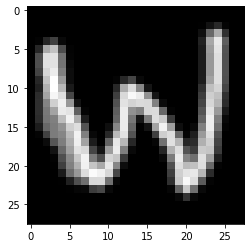

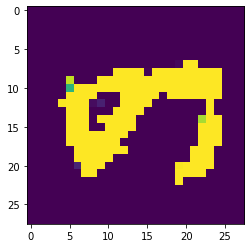

[2543.9336]


In [183]:
# We pass in an image of the letter W in the correct format for this exercise
from tensorflow.keras.preprocessing import image

img = image.load_img("img_Q52.png", target_size=(28, 28), 
                     color_mode = "grayscale")
plt.imshow(img, cmap='gray')
plt.show()

# Now we use our build_autoencoder function to try and predict the passed image
input_img = image.img_to_array(img)
inputs = input_img.reshape(1,784)
target_data = trained_model.model.predict(inputs)
plt.imshow(target_data.reshape(28,28))
plt.show()

dist = np.linalg.norm(inputs - target_data, axis=-1)
print(dist)

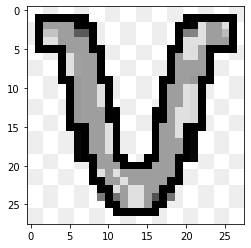

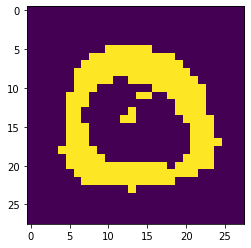

[5737.053]


In [184]:
# We pass in an image of the letter V in the correct format for this exercise
from tensorflow.keras.preprocessing import image

img = image.load_img("img_Q5.png", target_size=(28, 28), 
                     color_mode = "grayscale")
plt.imshow(img, cmap='gray')
plt.show()

# Now we use our build_autoencoder function to try and predict the passed image
input_img = image.img_to_array(img)
inputs = input_img.reshape(1,784)
target_data = trained_model.model.predict(inputs)
plt.imshow(target_data.reshape(28,28))
plt.show()

dist = np.linalg.norm(inputs - target_data, axis=-1)
print(dist)

### Results interpretation

As expected, the model fails when it encounters an image that it does not know. This is an important feature of the autoencoder, as we can use this to detect and/or filter out anomalies in our dataset.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# QUESTION 6

In this question, we will work under a Reinforce Learning framework. As a reminder, a Reinforce Learning framework is based on a environment that is composed by a set of possible states. Each state has an associated set of possible actions, which are chosen depending on a, sometimes prestablished, policy. Each action has a reward and transition probability associated with it. 

We will be trying to derive the Q-value matrix giving the value of each possible action in the environment presented below. This Q-value matrix tell us which is the prefered action a each state. The environment that we will analyze describes the structure of a financial market proposed by a financial strategist. We will be considering a discount factor for the probabilities set to 0.95.

The Q-values matrix will be found using the Optimal Bellman Equation which has the following form:

$$ Q_{*}(s,a)=\sum_{s',r}p(s',r|s,a)[r+\gamma\cdot max_{a'}Q_{*}(s',a')]$$

The Q-value is simply the expected value of the reward, given some policy. The Optimal Bellman Equation presented above can be, then, interpreted as the transition probability weighted average of the discounted rewards, where the discount factor is $\gamma$. 

- $p(s',r|s,a)$ represents the transition probabilites towards state $s'$ given that we start at state $s$ and we take the action $a$

The objective is to optimize the Q-value associated to each action at each state. This is done by solving the above equation in an iterative way.

In [185]:
import numpy as np
from matplotlib import image

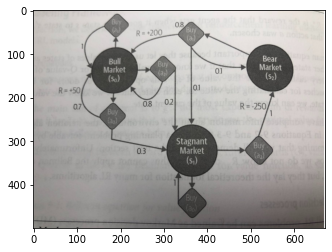

In [186]:
img = image.imread("img_Q6.png")
plt.imshow(img)

This is the graphic representation of the financial market proposed by the financial strategist (the environment). Now, we will start by setting the transition probabilities, rewards and possible actions for the Markov process based on the image above.

In [187]:
transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]]

rewards = [
    [[+50, 0, 0], [0, 0, 0], [0, 0, 0]], 
    [[0, 0, 0], [0, 0, 0], [0, 0, -250]],
    [[0, 0, 0], [+200, 0, 0], [0, 0, 0]]]

possible_actions = [[0, 1, 2], [0, 2], [1]]

We then, prepare a matrix for the Q-values with the dimensions of the action-state space: 3 by 3 in our case. It is important to intialize the values in such a manner that the values associated to inexistance actions at each state are very low.

In [188]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions 
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 # for all possible actions

Using the Bellman equation we calculate the Q-values and discount them at the set rate of 0.95.

In [189]:
gamma = 0.95 # the discount factor
for iteration in range(50): 
    Q_prev = Q_values.copy() 
    for s in range(3):
        for a in possible_actions[s]: 
            Q_values[s, a] = np.sum([transition_probabilities[s][a][sp]
                                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) 
                                for sp in range(3)])

Display of the optimal Q-values

In [190]:
Q_values

array([[108.66520942, 103.19039691,  83.50693858],
       [  4.77310528,         -inf,   5.06806034],
       [        -inf, 268.53643409,         -inf]])

As we can see, the optimal actions will be $a_{0}$ in state 0, $a_{2}$ in state 1 and $a_{1}$,the only possible action, in state 3.

Interestingly, the difference between the Q-values of actions 0 & 1 in state 0 and 0 & 2 in state 1 are not that different, meaning that it may be worth to try them out or to increase the number of iterations to see if the difference increases. But according to our calculations, the actions with the highest 'scores' are the best choice.

We can also see how high the Q-value is for $a_{1}$ in state 3, as it is the only possible action and all the positive rewards from the process are concentrated in this one score.